In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import monai.utils as utils

import torch

import matplotlib.pyplot as plt

import os
from glob import glob

import numpy as np

import itk

import site
site.addsitedir('../../../ARGUS')
from ARGUSUtils_Transforms import *


# In[2]:


img1_dir = "../../../Data/VFoldData/BAMC-PTX*Sliding-Annotations-Linear/"

all_images = sorted(glob(os.path.join(img1_dir, '*_?????.mha')))
all_labels = sorted(glob(os.path.join(img1_dir, '*.interpolated-overlay.mha')))

num_classes = 4
num_workers_tr = 4
batch_size_tr = 4
num_workers_vl = 4
batch_size_vl = 1

model_filename_base = "BAMC_PTX_3DUNet-4Class.best_model.vfold15"

num_images = len(all_images)
print(num_images)

num_folds = 15


ns_prefix = ['025ns','026ns','027ns','035ns','048ns','055ns','117ns',
             '135ns','193ns','210ns','215ns','218ns','219ns','221ns','247ns']
s_prefix = ['004s','019s','030s','034s','037s','043s','065s','081s',
            '206s','208s','211s','212s','224s','228s','236s','237s']

fold_prefix_list = []
ns_count = 0
s_count = 0
for i in range(num_folds):
    if i%2 == 0:
        num_ns = 1
        num_s = 1
        if i > num_folds-3:
            num_s = 2
    else:
        num_ns = 1
        num_s = 1
    f = []
    for ns in range(num_ns):
        f.append([ns_prefix[ns_count+ns]])
    ns_count += num_ns
    for s in range(num_s):
        f.append([s_prefix[s_count+s]])
    s_count += num_s
    fold_prefix_list.append(f)
        
train_files = []
val_files = []
test_files = []
for i in range(num_folds):
    tr_folds = []
    for f in range(i,i+num_folds-2):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    va_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-2) % num_folds]).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    train_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in tr_folds)],
                    [se for se in all_labels if any(pref in se for pref in tr_folds)])
            ]
        )
    val_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in va_folds)],
                    [se for se in all_labels if any(pref in se for pref in va_folds)])
            ]
        )
    test_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in te_folds)],
                    [se for se in all_labels if any(pref in se for pref in te_folds)])
            ]
        )
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))


# In[3]:


train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(keys=["image"],
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0),
        ARGUS_RandSpatialCropSlicesd(num_slices=48,
            axis=3,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=2,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=0,
            keys=['image', 'label']),
        RandZoomd(prob=0.5, 
            min_zoom=1.0,
            max_zoom=1.2,
            keys=['image', 'label'],
            keep_size=True,
            mode=['trilinear', 'nearest']),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(keys=["image"],
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0),
        ARGUS_RandSpatialCropSlicesd(num_slices=48,
            axis=3,
            center_slice=30,
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)

62
53 4 5
53 5 4
54 4 4
54 4 4
54 4 4
55 4 3
55 3 4
54 4 4
54 4 4
54 4 4
53 4 5
53 5 4
53 4 5
53 5 4
54 4 4


In [2]:
train_shape = itk.GetArrayFromImage(itk.imread(train_files[0][0]["image"])).shape
print(train_shape)

roi_size = [320,320,48]
print(roi_size)

(68, 320, 320)
[320, 320, 48]


In [3]:
# In[5]:


train_ds = [CacheDataset(data=train_files[i], transform=train_transforms,cache_rate=1.0, num_workers=num_workers_tr)
            for i in range(num_folds)]
train_loader = [DataLoader(train_ds[i], batch_size=batch_size_tr, shuffle=True, num_workers=num_workers_tr) 
                for i in range(num_folds)]

val_ds = [CacheDataset(data=val_files[i], transform=val_transforms, cache_rate=1.0, num_workers=num_workers_vl)
          for i in range(num_folds)]
val_loader = [DataLoader(val_ds[i], batch_size=batch_size_vl, num_workers=num_workers_vl)
              for i in range(num_folds)]


# In[6]:

Loading dataset: 100%|███████████████████████████| 4/4 [00:00<00:00, 121.99it/s]


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


Data Size = torch.Size([4, 1, 320, 320, 48])


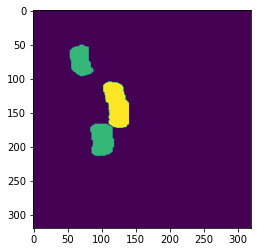

In [4]:
img = utils.first(train_loader[0])["label"]
print("Data Size =", img.shape)

plt.imshow(img[0,0,:,:,10])

In [ ]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
# In[7]:


def vfold_train(vfold_num, train_loader, val_loader):
    model = UNet(
        dimensions=3,
        in_channels=1,
        out_channels=num_classes,
        channels=(16, 32, 64, 128),
        strides=(2, 2, 2),
        num_res_units=2,
        norm=Norm.BATCH,
    ).to(device)
    loss_function = DiceLoss(to_onehot_y=True, softmax=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-4)
    dice_metric = DiceMetric(include_background=False, reduction="mean")


    max_epochs = 500
    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []
    post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, num_classes=num_classes)])
    post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=num_classes)])

    root_dir = "."

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"{vfold_num}: epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(
                f"{step}/{len(train_ds) // train_loader.batch_size}, "
                f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"{vfold_num} epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    sw_batch_size = batch_size_vl
                    val_outputs = sliding_window_inference(
                        val_inputs, roi_size, sw_batch_size, model)
                    val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    # compute metric for current iteration
                    dice_metric(y_pred=val_outputs, y=val_labels)

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()

                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(
                        root_dir, model_filename_base+'_'+str(vfold_num)+'.pth'))
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )

    np.save(model_filename_base+"_loss_"+str(vfold_num)+".npy", epoch_loss_values)
    np.save(model_filename_base+"_val_dice_"+str(vfold_num)+".npy", metric_values)

# In[ ]:


for i in range(num_folds):
    vfold_train(i, train_loader[i], val_loader[i])


# In[ ]:

----------
0: epoch 1/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.8653
2/3, train_loss: 0.8561
3/3, train_loss: 0.8637
4/3, train_loss: 0.8598
5/3, train_loss: 0.8527
6/3, train_loss: 0.8592
7/3, train_loss: 0.8523
8/3, train_loss: 0.8521
9/3, train_loss: 0.8499
10/3, train_loss: 0.8480
11/3, train_loss: 0.8567
12/3, train_loss: 0.8516
13/3, train_loss: 0.8442
14/3, train_loss: 0.8550
0 epoch 1 average loss: 0.8547
----------
0: epoch 2/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.8478
2/3, train_loss: 0.8451
3/3, train_loss: 0.8449
4/3, train_loss: 0.8441
5/3, train_loss: 0.8437
6/3, train_loss: 0.8470
7/3, train_loss: 0.8479
8/3, train_loss: 0.8423
9/3, train_loss: 0.8396
10/3, train_loss: 0.8423
11/3, train_loss: 0.8339
12/3, train_loss: 0.8374
13/3, train_loss: 0.8363
14/3, train_loss: 0.8247
0 epoch 2 average loss: 0.8412
saved new best metric model
current epoch: 2 current mean dice: 0.0758
best mean dice: 0.0758 at epoch: 2
----------
0: epoch 3/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.8361
2/3, train_loss: 0.8397
3/3, train_loss: 0.8375
4/3, train_loss: 0.8349
5/3, train_loss: 0.8294
6/3, train_loss: 0.8264
7/3, train_loss: 0.8290
8/3, train_loss: 0.8358
9/3, train_loss: 0.8331
10/3, train_loss: 0.8243
11/3, train_loss: 0.8255
12/3, train_loss: 0.8316
13/3, train_loss: 0.8242
14/3, train_loss: 0.8370
0 epoch 3 average loss: 0.8317
----------
0: epoch 4/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.8238
2/3, train_loss: 0.8212
3/3, train_loss: 0.8165
4/3, train_loss: 0.8253
5/3, train_loss: 0.8232
6/3, train_loss: 0.8226
7/3, train_loss: 0.8293
8/3, train_loss: 0.8212
9/3, train_loss: 0.8300
10/3, train_loss: 0.8194
11/3, train_loss: 0.8178
12/3, train_loss: 0.8266
13/3, train_loss: 0.8139
14/3, train_loss: 0.8246
0 epoch 4 average loss: 0.8225
saved new best metric model
current epoch: 4 current mean dice: 0.1128
best mean dice: 0.1128 at epoch: 4
----------
0: epoch 5/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.8207
2/3, train_loss: 0.8220
3/3, train_loss: 0.8224
4/3, train_loss: 0.8182
5/3, train_loss: 0.8175
6/3, train_loss: 0.8150
7/3, train_loss: 0.8039
8/3, train_loss: 0.8137
9/3, train_loss: 0.8091
10/3, train_loss: 0.8148
11/3, train_loss: 0.7989
12/3, train_loss: 0.8178
13/3, train_loss: 0.7997
14/3, train_loss: 0.8088
0 epoch 5 average loss: 0.8131
----------
0: epoch 6/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.8051
2/3, train_loss: 0.8099
3/3, train_loss: 0.8020
4/3, train_loss: 0.8055
5/3, train_loss: 0.8045
6/3, train_loss: 0.8065
7/3, train_loss: 0.8041
8/3, train_loss: 0.8022
9/3, train_loss: 0.8064
10/3, train_loss: 0.8037
11/3, train_loss: 0.8044
12/3, train_loss: 0.7967
13/3, train_loss: 0.7906
14/3, train_loss: 0.8185
0 epoch 6 average loss: 0.8043
saved new best metric model
current epoch: 6 current mean dice: 0.1281
best mean dice: 0.1281 at epoch: 6
----------
0: epoch 7/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.7998
2/3, train_loss: 0.8017
3/3, train_loss: 0.8060
4/3, train_loss: 0.7915
5/3, train_loss: 0.8010
6/3, train_loss: 0.7994
7/3, train_loss: 0.7890
8/3, train_loss: 0.8013
9/3, train_loss: 0.7854
10/3, train_loss: 0.7872
11/3, train_loss: 0.7833
12/3, train_loss: 0.7898
13/3, train_loss: 0.7954
14/3, train_loss: 0.8011
0 epoch 7 average loss: 0.7951
----------
0: epoch 8/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.7814
2/3, train_loss: 0.7930
3/3, train_loss: 0.7920
4/3, train_loss: 0.7955
5/3, train_loss: 0.7827
6/3, train_loss: 0.7912
7/3, train_loss: 0.7954
8/3, train_loss: 0.7804
9/3, train_loss: 0.7751
10/3, train_loss: 0.7867
11/3, train_loss: 0.7733
12/3, train_loss: 0.7775
13/3, train_loss: 0.7903
14/3, train_loss: 0.7685
0 epoch 8 average loss: 0.7845
saved new best metric model
current epoch: 8 current mean dice: 0.1777
best mean dice: 0.1777 at epoch: 8
----------
0: epoch 9/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.7749
2/3, train_loss: 0.7671
3/3, train_loss: 0.7734
4/3, train_loss: 0.7735
5/3, train_loss: 0.7699
6/3, train_loss: 0.7698
7/3, train_loss: 0.7662
8/3, train_loss: 0.7906
9/3, train_loss: 0.7860
10/3, train_loss: 0.7645
11/3, train_loss: 0.7718
12/3, train_loss: 0.7728
13/3, train_loss: 0.7923
14/3, train_loss: 0.7312
0 epoch 9 average loss: 0.7717
----------
0: epoch 10/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.7655
2/3, train_loss: 0.7791
3/3, train_loss: 0.7615
4/3, train_loss: 0.7716
5/3, train_loss: 0.7850
6/3, train_loss: 0.7728
7/3, train_loss: 0.7693
8/3, train_loss: 0.7347
9/3, train_loss: 0.7733
10/3, train_loss: 0.7627
11/3, train_loss: 0.7569
12/3, train_loss: 0.7471
13/3, train_loss: 0.7615
14/3, train_loss: 0.7445
0 epoch 10 average loss: 0.7632
saved new best metric model
current epoch: 10 current mean dice: 0.2045
best mean dice: 0.2045 at epoch: 10
----------
0: epoch 11/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.7714
2/3, train_loss: 0.7487
3/3, train_loss: 0.7549
4/3, train_loss: 0.7687
5/3, train_loss: 0.7518
6/3, train_loss: 0.7477
7/3, train_loss: 0.7667
8/3, train_loss: 0.7216
9/3, train_loss: 0.7428
10/3, train_loss: 0.7629
11/3, train_loss: 0.7455
12/3, train_loss: 0.7491
13/3, train_loss: 0.7458
14/3, train_loss: 0.7560
0 epoch 11 average loss: 0.7524
----------
0: epoch 12/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.7424
2/3, train_loss: 0.7560
3/3, train_loss: 0.7649
4/3, train_loss: 0.7337
5/3, train_loss: 0.7263
6/3, train_loss: 0.7196
7/3, train_loss: 0.7351
8/3, train_loss: 0.7310
9/3, train_loss: 0.7471
10/3, train_loss: 0.7455
11/3, train_loss: 0.7472
12/3, train_loss: 0.7335
13/3, train_loss: 0.7514
14/3, train_loss: 0.7639
0 epoch 12 average loss: 0.7427
saved new best metric model
current epoch: 12 current mean dice: 0.2840
best mean dice: 0.2840 at epoch: 12
----------
0: epoch 13/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.7464
2/3, train_loss: 0.7254
3/3, train_loss: 0.7246
4/3, train_loss: 0.7325
5/3, train_loss: 0.7300
6/3, train_loss: 0.7227
7/3, train_loss: 0.7279
8/3, train_loss: 0.7391
9/3, train_loss: 0.7218
10/3, train_loss: 0.7219
11/3, train_loss: 0.7393
12/3, train_loss: 0.7478
13/3, train_loss: 0.7443
14/3, train_loss: 0.7307
0 epoch 13 average loss: 0.7325
----------
0: epoch 14/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.7326
2/3, train_loss: 0.7292
3/3, train_loss: 0.7103
4/3, train_loss: 0.7349
5/3, train_loss: 0.7377
6/3, train_loss: 0.6995
7/3, train_loss: 0.7303
8/3, train_loss: 0.7023
9/3, train_loss: 0.7074
10/3, train_loss: 0.7365
11/3, train_loss: 0.7318
12/3, train_loss: 0.7354
13/3, train_loss: 0.7219
14/3, train_loss: 0.7662
0 epoch 14 average loss: 0.7269
current epoch: 14 current mean dice: 0.1999
best mean dice: 0.2840 at epoch: 12
----------
0: epoch 15/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.7483
2/3, train_loss: 0.7225
3/3, train_loss: 0.7024
4/3, train_loss: 0.7018
5/3, train_loss: 0.7250
6/3, train_loss: 0.7150
7/3, train_loss: 0.7025
8/3, train_loss: 0.7252
9/3, train_loss: 0.7172
10/3, train_loss: 0.7005
11/3, train_loss: 0.7198
12/3, train_loss: 0.7123
13/3, train_loss: 0.7277
14/3, train_loss: 0.6757
0 epoch 15 average loss: 0.7140
----------
0: epoch 16/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.7144
2/3, train_loss: 0.7379
3/3, train_loss: 0.6909
4/3, train_loss: 0.7121
5/3, train_loss: 0.7066
6/3, train_loss: 0.7068
7/3, train_loss: 0.7139
8/3, train_loss: 0.6913
9/3, train_loss: 0.7027
10/3, train_loss: 0.7174
11/3, train_loss: 0.7055
12/3, train_loss: 0.6769
13/3, train_loss: 0.7163
14/3, train_loss: 0.6877
0 epoch 16 average loss: 0.7057
current epoch: 16 current mean dice: 0.2780
best mean dice: 0.2840 at epoch: 12
----------
0: epoch 17/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.6969
2/3, train_loss: 0.7285
3/3, train_loss: 0.7115
4/3, train_loss: 0.7209
5/3, train_loss: 0.6802
6/3, train_loss: 0.6858
7/3, train_loss: 0.6932
8/3, train_loss: 0.7018
9/3, train_loss: 0.7070
10/3, train_loss: 0.6920
11/3, train_loss: 0.6740
12/3, train_loss: 0.6919
13/3, train_loss: 0.6824
14/3, train_loss: 0.7271
0 epoch 17 average loss: 0.6995
----------
0: epoch 18/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.6732
2/3, train_loss: 0.6992
3/3, train_loss: 0.6984
4/3, train_loss: 0.6722
5/3, train_loss: 0.6837
6/3, train_loss: 0.6844
7/3, train_loss: 0.6876
8/3, train_loss: 0.6956
9/3, train_loss: 0.7088
10/3, train_loss: 0.6864
11/3, train_loss: 0.6877
12/3, train_loss: 0.6874
13/3, train_loss: 0.6460
14/3, train_loss: 0.7025
0 epoch 18 average loss: 0.6867
saved new best metric model
current epoch: 18 current mean dice: 0.2987
best mean dice: 0.2987 at epoch: 18
----------
0: epoch 19/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.6926
2/3, train_loss: 0.6472
3/3, train_loss: 0.6869
4/3, train_loss: 0.6771
5/3, train_loss: 0.6736
6/3, train_loss: 0.7301
7/3, train_loss: 0.6717
8/3, train_loss: 0.6910
9/3, train_loss: 0.6711
10/3, train_loss: 0.6587
11/3, train_loss: 0.6837
12/3, train_loss: 0.6673
13/3, train_loss: 0.6665
14/3, train_loss: 0.6735
0 epoch 19 average loss: 0.6779
----------
0: epoch 20/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.6593
2/3, train_loss: 0.6561
3/3, train_loss: 0.6957
4/3, train_loss: 0.6710
5/3, train_loss: 0.6624
6/3, train_loss: 0.6823
7/3, train_loss: 0.6660
8/3, train_loss: 0.6475
9/3, train_loss: 0.6729
10/3, train_loss: 0.6599
11/3, train_loss: 0.6746
12/3, train_loss: 0.6520
13/3, train_loss: 0.6356
14/3, train_loss: 0.6752
0 epoch 20 average loss: 0.6650
current epoch: 20 current mean dice: 0.2560
best mean dice: 0.2987 at epoch: 18
----------
0: epoch 21/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.6267
2/3, train_loss: 0.6650
3/3, train_loss: 0.6128
4/3, train_loss: 0.6490
5/3, train_loss: 0.6953
6/3, train_loss: 0.6765
7/3, train_loss: 0.6569
8/3, train_loss: 0.6318
9/3, train_loss: 0.6536
10/3, train_loss: 0.6485
11/3, train_loss: 0.6785
12/3, train_loss: 0.6574
13/3, train_loss: 0.6621
14/3, train_loss: 0.6376
0 epoch 21 average loss: 0.6537
----------
0: epoch 22/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.6284
2/3, train_loss: 0.6256
3/3, train_loss: 0.6136
4/3, train_loss: 0.6363
5/3, train_loss: 0.6481
6/3, train_loss: 0.6615
7/3, train_loss: 0.6934
8/3, train_loss: 0.6371
9/3, train_loss: 0.6800
10/3, train_loss: 0.6371
11/3, train_loss: 0.6352
12/3, train_loss: 0.6577
13/3, train_loss: 0.6470
14/3, train_loss: 0.6967
0 epoch 22 average loss: 0.6498
saved new best metric model
current epoch: 22 current mean dice: 0.3275
best mean dice: 0.3275 at epoch: 22
----------
0: epoch 23/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.6632
2/3, train_loss: 0.6335
3/3, train_loss: 0.6604
4/3, train_loss: 0.6333
5/3, train_loss: 0.6854
6/3, train_loss: 0.6204
7/3, train_loss: 0.6404
8/3, train_loss: 0.6476
9/3, train_loss: 0.6507
10/3, train_loss: 0.6682
11/3, train_loss: 0.6178
12/3, train_loss: 0.6158
13/3, train_loss: 0.6121
14/3, train_loss: 0.6847
0 epoch 23 average loss: 0.6452
----------
0: epoch 24/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.6408
2/3, train_loss: 0.6433
3/3, train_loss: 0.6419
4/3, train_loss: 0.6148
5/3, train_loss: 0.5982
6/3, train_loss: 0.6243
7/3, train_loss: 0.6013
8/3, train_loss: 0.6515
9/3, train_loss: 0.5872
10/3, train_loss: 0.6638
11/3, train_loss: 0.6668
12/3, train_loss: 0.6309
13/3, train_loss: 0.6248
14/3, train_loss: 0.6281
0 epoch 24 average loss: 0.6298
current epoch: 24 current mean dice: 0.2792
best mean dice: 0.3275 at epoch: 22
----------
0: epoch 25/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.6446
2/3, train_loss: 0.6470
3/3, train_loss: 0.6473
4/3, train_loss: 0.6272
5/3, train_loss: 0.6707
6/3, train_loss: 0.6089
7/3, train_loss: 0.6379
8/3, train_loss: 0.6292
9/3, train_loss: 0.6248
10/3, train_loss: 0.6274
11/3, train_loss: 0.6031
12/3, train_loss: 0.6291
13/3, train_loss: 0.5991
14/3, train_loss: 0.6236
0 epoch 25 average loss: 0.6300
----------
0: epoch 26/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.6250
2/3, train_loss: 0.6500
3/3, train_loss: 0.5867
4/3, train_loss: 0.6236
5/3, train_loss: 0.5995
6/3, train_loss: 0.5864
7/3, train_loss: 0.5930
8/3, train_loss: 0.6550
9/3, train_loss: 0.6484
10/3, train_loss: 0.6034
11/3, train_loss: 0.6005
12/3, train_loss: 0.6373
13/3, train_loss: 0.6321
14/3, train_loss: 0.6108
0 epoch 26 average loss: 0.6180
saved new best metric model
current epoch: 26 current mean dice: 0.3641
best mean dice: 0.3641 at epoch: 26
----------
0: epoch 27/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.6142
2/3, train_loss: 0.6073
3/3, train_loss: 0.6007
4/3, train_loss: 0.6071
5/3, train_loss: 0.6107
6/3, train_loss: 0.6282
7/3, train_loss: 0.6160
8/3, train_loss: 0.6124
9/3, train_loss: 0.6160
10/3, train_loss: 0.6464
11/3, train_loss: 0.5758
12/3, train_loss: 0.6068
13/3, train_loss: 0.5901
14/3, train_loss: 0.5722
0 epoch 27 average loss: 0.6074
----------
0: epoch 28/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.5746
2/3, train_loss: 0.6674
3/3, train_loss: 0.6072
4/3, train_loss: 0.6182
5/3, train_loss: 0.6155
6/3, train_loss: 0.6045
7/3, train_loss: 0.5772
8/3, train_loss: 0.5996
9/3, train_loss: 0.5588
10/3, train_loss: 0.6142
11/3, train_loss: 0.5701
12/3, train_loss: 0.5818
13/3, train_loss: 0.6000
14/3, train_loss: 0.5731
0 epoch 28 average loss: 0.5973
current epoch: 28 current mean dice: 0.3217
best mean dice: 0.3641 at epoch: 26
----------
0: epoch 29/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.6496


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


2/3, train_loss: 0.5969
3/3, train_loss: 0.5981
4/3, train_loss: 0.5902
5/3, train_loss: 0.5727
6/3, train_loss: 0.5879
7/3, train_loss: 0.5776
8/3, train_loss: 0.5916
9/3, train_loss: 0.5889
10/3, train_loss: 0.6046
11/3, train_loss: 0.5824
12/3, train_loss: 0.5710
13/3, train_loss: 0.6156
14/3, train_loss: 0.5165
0 epoch 29 average loss: 0.5888
----------
0: epoch 30/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.5543


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


2/3, train_loss: 0.6216
3/3, train_loss: 0.6006
4/3, train_loss: 0.5932
5/3, train_loss: 0.5619
6/3, train_loss: 0.6132
7/3, train_loss: 0.5800
8/3, train_loss: 0.5566
9/3, train_loss: 0.5742
10/3, train_loss: 0.5557
11/3, train_loss: 0.6194
12/3, train_loss: 0.5610
13/3, train_loss: 0.6076
14/3, train_loss: 0.6693
0 epoch 30 average loss: 0.5906
current epoch: 30 current mean dice: 0.3507
best mean dice: 0.3641 at epoch: 26
----------
0: epoch 31/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.6278
2/3, train_loss: 0.5992
3/3, train_loss: 0.6268
4/3, train_loss: 0.5821
5/3, train_loss: 0.5509
6/3, train_loss: 0.6101
7/3, train_loss: 0.5789
8/3, train_loss: 0.5369
9/3, train_loss: 0.5538
10/3, train_loss: 0.5799
11/3, train_loss: 0.5820
12/3, train_loss: 0.5675
13/3, train_loss: 0.5417
14/3, train_loss: 0.5536
0 epoch 31 average loss: 0.5779
----------
0: epoch 32/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.5938
2/3, train_loss: 0.5561
3/3, train_loss: 0.5644
4/3, train_loss: 0.5897
5/3, train_loss: 0.5472
6/3, train_loss: 0.5685
7/3, train_loss: 0.6017
8/3, train_loss: 0.5503
9/3, train_loss: 0.5656
10/3, train_loss: 0.5456
11/3, train_loss: 0.6377
12/3, train_loss: 0.5799
13/3, train_loss: 0.5309
14/3, train_loss: 0.5982
0 epoch 32 average loss: 0.5735
current epoch: 32 current mean dice: 0.2923
best mean dice: 0.3641 at epoch: 26
----------
0: epoch 33/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.5316
2/3, train_loss: 0.5667
3/3, train_loss: 0.5182
4/3, train_loss: 0.5576
5/3, train_loss: 0.5689
6/3, train_loss: 0.5636
7/3, train_loss: 0.5889
8/3, train_loss: 0.5958
9/3, train_loss: 0.5582
10/3, train_loss: 0.5734
11/3, train_loss: 0.5609
12/3, train_loss: 0.5681
13/3, train_loss: 0.5867
14/3, train_loss: 0.5368
0 epoch 33 average loss: 0.5625
----------
0: epoch 34/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.5575
2/3, train_loss: 0.5310
3/3, train_loss: 0.5570
4/3, train_loss: 0.5586
5/3, train_loss: 0.5867
6/3, train_loss: 0.5139
7/3, train_loss: 0.5974
8/3, train_loss: 0.5782
9/3, train_loss: 0.5417
10/3, train_loss: 0.5680
11/3, train_loss: 0.5573
12/3, train_loss: 0.5180
13/3, train_loss: 0.6105
14/3, train_loss: 0.5131
0 epoch 34 average loss: 0.5563
current epoch: 34 current mean dice: 0.2717
best mean dice: 0.3641 at epoch: 26
----------
0: epoch 35/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.5169
2/3, train_loss: 0.5650
3/3, train_loss: 0.5596
4/3, train_loss: 0.5045
5/3, train_loss: 0.5399
6/3, train_loss: 0.5682
7/3, train_loss: 0.5130
8/3, train_loss: 0.5246
9/3, train_loss: 0.5689
10/3, train_loss: 0.5576
11/3, train_loss: 0.6024
12/3, train_loss: 0.5680
13/3, train_loss: 0.5770
14/3, train_loss: 0.5925
0 epoch 35 average loss: 0.5541
----------
0: epoch 36/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.5460
2/3, train_loss: 0.5137
3/3, train_loss: 0.6013
4/3, train_loss: 0.5392
5/3, train_loss: 0.5549
6/3, train_loss: 0.6350
7/3, train_loss: 0.5487
8/3, train_loss: 0.5739
9/3, train_loss: 0.6024
10/3, train_loss: 0.5432
11/3, train_loss: 0.5492
12/3, train_loss: 0.5177
13/3, train_loss: 0.5313
14/3, train_loss: 0.5580
0 epoch 36 average loss: 0.5582
current epoch: 36 current mean dice: 0.3285
best mean dice: 0.3641 at epoch: 26
----------
0: epoch 37/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.5419
2/3, train_loss: 0.5199
3/3, train_loss: 0.4810
4/3, train_loss: 0.5875
5/3, train_loss: 0.5594
6/3, train_loss: 0.5739
7/3, train_loss: 0.5397
8/3, train_loss: 0.5891
9/3, train_loss: 0.5082
10/3, train_loss: 0.5334
11/3, train_loss: 0.5530
12/3, train_loss: 0.5594
13/3, train_loss: 0.5610
14/3, train_loss: 0.6080
0 epoch 37 average loss: 0.5511
----------
0: epoch 38/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.5139
2/3, train_loss: 0.5566
3/3, train_loss: 0.5296
4/3, train_loss: 0.5495
5/3, train_loss: 0.5288
6/3, train_loss: 0.5092
7/3, train_loss: 0.5339
8/3, train_loss: 0.5814
9/3, train_loss: 0.5769
10/3, train_loss: 0.5354
11/3, train_loss: 0.5376
12/3, train_loss: 0.5719
13/3, train_loss: 0.5539
14/3, train_loss: 0.5349
0 epoch 38 average loss: 0.5438
saved new best metric model
current epoch: 38 current mean dice: 0.5018
best mean dice: 0.5018 at epoch: 38
----------
0: epoch 39/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.5236
2/3, train_loss: 0.5175
3/3, train_loss: 0.5232
4/3, train_loss: 0.5127
5/3, train_loss: 0.4867
6/3, train_loss: 0.5300
7/3, train_loss: 0.5559
8/3, train_loss: 0.5266
9/3, train_loss: 0.5504
10/3, train_loss: 0.5464
11/3, train_loss: 0.5113
12/3, train_loss: 0.5483
13/3, train_loss: 0.5675
14/3, train_loss: 0.5200
0 epoch 39 average loss: 0.5300
----------
0: epoch 40/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.5328
2/3, train_loss: 0.5465
3/3, train_loss: 0.5503
4/3, train_loss: 0.5144
5/3, train_loss: 0.5206
6/3, train_loss: 0.5162
7/3, train_loss: 0.5354
8/3, train_loss: 0.5057
9/3, train_loss: 0.5023
10/3, train_loss: 0.5223
11/3, train_loss: 0.4916
12/3, train_loss: 0.5900
13/3, train_loss: 0.5531
14/3, train_loss: 0.5090
0 epoch 40 average loss: 0.5279
current epoch: 40 current mean dice: 0.1573
best mean dice: 0.5018 at epoch: 38
----------
0: epoch 41/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.5732
2/3, train_loss: 0.5123
3/3, train_loss: 0.5225
4/3, train_loss: 0.5283
5/3, train_loss: 0.5244
6/3, train_loss: 0.5359
7/3, train_loss: 0.5291
8/3, train_loss: 0.5579
9/3, train_loss: 0.5421
10/3, train_loss: 0.4900
11/3, train_loss: 0.5067
12/3, train_loss: 0.5401
13/3, train_loss: 0.4681
14/3, train_loss: 0.6021
0 epoch 41 average loss: 0.5309
----------
0: epoch 42/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4982
2/3, train_loss: 0.4932
3/3, train_loss: 0.5156
4/3, train_loss: 0.4967
5/3, train_loss: 0.5645
6/3, train_loss: 0.5068
7/3, train_loss: 0.5633
8/3, train_loss: 0.4917
9/3, train_loss: 0.5336
10/3, train_loss: 0.5637
11/3, train_loss: 0.5015
12/3, train_loss: 0.5157
13/3, train_loss: 0.5387
14/3, train_loss: 0.5688
0 epoch 42 average loss: 0.5251
current epoch: 42 current mean dice: 0.3723
best mean dice: 0.5018 at epoch: 38
----------
0: epoch 43/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.5382
2/3, train_loss: 0.4629
3/3, train_loss: 0.5440
4/3, train_loss: 0.5482
5/3, train_loss: 0.5293
6/3, train_loss: 0.5271
7/3, train_loss: 0.5073
8/3, train_loss: 0.5162
9/3, train_loss: 0.5394
10/3, train_loss: 0.5395
11/3, train_loss: 0.5008
12/3, train_loss: 0.5287
13/3, train_loss: 0.4951
14/3, train_loss: 0.4855
0 epoch 43 average loss: 0.5187
----------
0: epoch 44/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.5212
2/3, train_loss: 0.5359
3/3, train_loss: 0.5052
4/3, train_loss: 0.5230
5/3, train_loss: 0.4652
6/3, train_loss: 0.5435
7/3, train_loss: 0.5561
8/3, train_loss: 0.5280
9/3, train_loss: 0.4886
10/3, train_loss: 0.5122
11/3, train_loss: 0.4965
12/3, train_loss: 0.5489
13/3, train_loss: 0.5282
14/3, train_loss: 0.4910
0 epoch 44 average loss: 0.5174
current epoch: 44 current mean dice: 0.3353
best mean dice: 0.5018 at epoch: 38
----------
0: epoch 45/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.5251
2/3, train_loss: 0.5091
3/3, train_loss: 0.4996
4/3, train_loss: 0.5004
5/3, train_loss: 0.5347
6/3, train_loss: 0.4928
7/3, train_loss: 0.5233
8/3, train_loss: 0.4764
9/3, train_loss: 0.4728
10/3, train_loss: 0.4979
11/3, train_loss: 0.5410
12/3, train_loss: 0.5074
13/3, train_loss: 0.5215
14/3, train_loss: 0.4395
0 epoch 45 average loss: 0.5029
----------
0: epoch 46/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.5502
2/3, train_loss: 0.4613
3/3, train_loss: 0.5483
4/3, train_loss: 0.5133
5/3, train_loss: 0.5158
6/3, train_loss: 0.4660
7/3, train_loss: 0.5051
8/3, train_loss: 0.4791
9/3, train_loss: 0.4964
10/3, train_loss: 0.5002
11/3, train_loss: 0.5081
12/3, train_loss: 0.5504
13/3, train_loss: 0.4578
14/3, train_loss: 0.5960
0 epoch 46 average loss: 0.5106
current epoch: 46 current mean dice: 0.2436
best mean dice: 0.5018 at epoch: 38
----------
0: epoch 47/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4904
2/3, train_loss: 0.4958
3/3, train_loss: 0.4916
4/3, train_loss: 0.5482
5/3, train_loss: 0.5072
6/3, train_loss: 0.5241
7/3, train_loss: 0.5092
8/3, train_loss: 0.4937
9/3, train_loss: 0.4935
10/3, train_loss: 0.4778
11/3, train_loss: 0.4547
12/3, train_loss: 0.5862
13/3, train_loss: 0.5457
14/3, train_loss: 0.5461
0 epoch 47 average loss: 0.5117
----------
0: epoch 48/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4559
2/3, train_loss: 0.5050
3/3, train_loss: 0.4828
4/3, train_loss: 0.5069
5/3, train_loss: 0.5260
6/3, train_loss: 0.5084
7/3, train_loss: 0.5386
8/3, train_loss: 0.4867
9/3, train_loss: 0.4793
10/3, train_loss: 0.5009
11/3, train_loss: 0.4741
12/3, train_loss: 0.5190
13/3, train_loss: 0.5328
14/3, train_loss: 0.5266
0 epoch 48 average loss: 0.5031
current epoch: 48 current mean dice: 0.3691
best mean dice: 0.5018 at epoch: 38
----------
0: epoch 49/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4776
2/3, train_loss: 0.4964
3/3, train_loss: 0.4886
4/3, train_loss: 0.5396
5/3, train_loss: 0.4878
6/3, train_loss: 0.4999
7/3, train_loss: 0.5081
8/3, train_loss: 0.5171
9/3, train_loss: 0.4826
10/3, train_loss: 0.4770
11/3, train_loss: 0.4997
12/3, train_loss: 0.4504
13/3, train_loss: 0.4786
14/3, train_loss: 0.5601
0 epoch 49 average loss: 0.4974
----------
0: epoch 50/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4642
2/3, train_loss: 0.5020
3/3, train_loss: 0.5364
4/3, train_loss: 0.5058
5/3, train_loss: 0.4845
6/3, train_loss: 0.4473
7/3, train_loss: 0.4818
8/3, train_loss: 0.4864
9/3, train_loss: 0.4913
10/3, train_loss: 0.4802
11/3, train_loss: 0.5387
12/3, train_loss: 0.5294
13/3, train_loss: 0.4791
14/3, train_loss: 0.6128
0 epoch 50 average loss: 0.5029
current epoch: 50 current mean dice: 0.4177
best mean dice: 0.5018 at epoch: 38
----------
0: epoch 51/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4619
2/3, train_loss: 0.4839
3/3, train_loss: 0.5115
4/3, train_loss: 0.5107
5/3, train_loss: 0.4939
6/3, train_loss: 0.5039
7/3, train_loss: 0.5067
8/3, train_loss: 0.4947
9/3, train_loss: 0.5158
10/3, train_loss: 0.5208
11/3, train_loss: 0.4829
12/3, train_loss: 0.5216
13/3, train_loss: 0.5113
14/3, train_loss: 0.5383
0 epoch 51 average loss: 0.5041
----------
0: epoch 52/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.5178
2/3, train_loss: 0.5012
3/3, train_loss: 0.5091
4/3, train_loss: 0.4827
5/3, train_loss: 0.4679
6/3, train_loss: 0.5276
7/3, train_loss: 0.4858
8/3, train_loss: 0.5125
9/3, train_loss: 0.5378
10/3, train_loss: 0.4949
11/3, train_loss: 0.4844
12/3, train_loss: 0.4737
13/3, train_loss: 0.5238
14/3, train_loss: 0.4559
0 epoch 52 average loss: 0.4982
current epoch: 52 current mean dice: 0.3744
best mean dice: 0.5018 at epoch: 38
----------
0: epoch 53/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4762
2/3, train_loss: 0.5028
3/3, train_loss: 0.4519
4/3, train_loss: 0.4898
5/3, train_loss: 0.5218
6/3, train_loss: 0.5492
7/3, train_loss: 0.5112
8/3, train_loss: 0.5195
9/3, train_loss: 0.4741
10/3, train_loss: 0.4956
11/3, train_loss: 0.4984
12/3, train_loss: 0.5250
13/3, train_loss: 0.4708
14/3, train_loss: 0.4651
0 epoch 53 average loss: 0.4965
----------
0: epoch 54/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.5088
2/3, train_loss: 0.5045
3/3, train_loss: 0.4733
4/3, train_loss: 0.5031
5/3, train_loss: 0.4913
6/3, train_loss: 0.4601
7/3, train_loss: 0.4845
8/3, train_loss: 0.5086
9/3, train_loss: 0.4468
10/3, train_loss: 0.5193
11/3, train_loss: 0.4876
12/3, train_loss: 0.5289
13/3, train_loss: 0.4795
14/3, train_loss: 0.4240
0 epoch 54 average loss: 0.4872
current epoch: 54 current mean dice: 0.3574
best mean dice: 0.5018 at epoch: 38
----------
0: epoch 55/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.5440
2/3, train_loss: 0.4644
3/3, train_loss: 0.4588
4/3, train_loss: 0.4710
5/3, train_loss: 0.4646
6/3, train_loss: 0.4684
7/3, train_loss: 0.5029
8/3, train_loss: 0.4450
9/3, train_loss: 0.4888
10/3, train_loss: 0.4625
11/3, train_loss: 0.4813
12/3, train_loss: 0.4635
13/3, train_loss: 0.4854
14/3, train_loss: 0.5716
0 epoch 55 average loss: 0.4837
----------
0: epoch 56/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4883
2/3, train_loss: 0.4567
3/3, train_loss: 0.4575
4/3, train_loss: 0.5179
5/3, train_loss: 0.5535
6/3, train_loss: 0.4945
7/3, train_loss: 0.5076
8/3, train_loss: 0.4744
9/3, train_loss: 0.4837
10/3, train_loss: 0.5001
11/3, train_loss: 0.4591
12/3, train_loss: 0.4586
13/3, train_loss: 0.4647
14/3, train_loss: 0.4674
0 epoch 56 average loss: 0.4846
current epoch: 56 current mean dice: 0.2380
best mean dice: 0.5018 at epoch: 38
----------
0: epoch 57/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4691
2/3, train_loss: 0.4318
3/3, train_loss: 0.4585
4/3, train_loss: 0.4641
5/3, train_loss: 0.4704
6/3, train_loss: 0.4995
7/3, train_loss: 0.5080
8/3, train_loss: 0.4972
9/3, train_loss: 0.4589
10/3, train_loss: 0.5253
11/3, train_loss: 0.5298
12/3, train_loss: 0.4771
13/3, train_loss: 0.4794
14/3, train_loss: 0.4984
0 epoch 57 average loss: 0.4834
----------
0: epoch 58/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4863
2/3, train_loss: 0.4466
3/3, train_loss: 0.5320
4/3, train_loss: 0.4965
5/3, train_loss: 0.5182
6/3, train_loss: 0.4949
7/3, train_loss: 0.4977
8/3, train_loss: 0.4833
9/3, train_loss: 0.4286
10/3, train_loss: 0.4787
11/3, train_loss: 0.4694
12/3, train_loss: 0.4742
13/3, train_loss: 0.4578
14/3, train_loss: 0.5879
0 epoch 58 average loss: 0.4894
current epoch: 58 current mean dice: 0.3989
best mean dice: 0.5018 at epoch: 38
----------
0: epoch 59/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4428
2/3, train_loss: 0.4865
3/3, train_loss: 0.4487
4/3, train_loss: 0.4815
5/3, train_loss: 0.4561
6/3, train_loss: 0.5210
7/3, train_loss: 0.4933
8/3, train_loss: 0.4900
9/3, train_loss: 0.4538
10/3, train_loss: 0.4741
11/3, train_loss: 0.4612
12/3, train_loss: 0.4828
13/3, train_loss: 0.4756
14/3, train_loss: 0.5246
0 epoch 59 average loss: 0.4780
----------
0: epoch 60/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4484
2/3, train_loss: 0.4632
3/3, train_loss: 0.4648
4/3, train_loss: 0.4789
5/3, train_loss: 0.4719
6/3, train_loss: 0.4868
7/3, train_loss: 0.4372
8/3, train_loss: 0.4292
9/3, train_loss: 0.4627
10/3, train_loss: 0.4452
11/3, train_loss: 0.5026
12/3, train_loss: 0.4963
13/3, train_loss: 0.4921
14/3, train_loss: 0.5348
0 epoch 60 average loss: 0.4724
current epoch: 60 current mean dice: 0.3129
best mean dice: 0.5018 at epoch: 38
----------
0: epoch 61/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4571
2/3, train_loss: 0.4755
3/3, train_loss: 0.4342
4/3, train_loss: 0.4662
5/3, train_loss: 0.4654
6/3, train_loss: 0.4674
7/3, train_loss: 0.4474
8/3, train_loss: 0.4608
9/3, train_loss: 0.4775
10/3, train_loss: 0.4573
11/3, train_loss: 0.4846
12/3, train_loss: 0.4502
13/3, train_loss: 0.4388
14/3, train_loss: 0.4956
0 epoch 61 average loss: 0.4627
----------
0: epoch 62/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4381
2/3, train_loss: 0.5066
3/3, train_loss: 0.4821
4/3, train_loss: 0.4277
5/3, train_loss: 0.4738
6/3, train_loss: 0.4741
7/3, train_loss: 0.4351
8/3, train_loss: 0.5120
9/3, train_loss: 0.4534
10/3, train_loss: 0.4570
11/3, train_loss: 0.4507
12/3, train_loss: 0.4513
13/3, train_loss: 0.4914
14/3, train_loss: 0.4188
0 epoch 62 average loss: 0.4623
current epoch: 62 current mean dice: 0.5004
best mean dice: 0.5018 at epoch: 38
----------
0: epoch 63/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4885
2/3, train_loss: 0.4766
3/3, train_loss: 0.4481
4/3, train_loss: 0.4577
5/3, train_loss: 0.4509
6/3, train_loss: 0.4268
7/3, train_loss: 0.4611
8/3, train_loss: 0.4405
9/3, train_loss: 0.4558
10/3, train_loss: 0.4581
11/3, train_loss: 0.4793
12/3, train_loss: 0.5080
13/3, train_loss: 0.4409
14/3, train_loss: 0.4161
0 epoch 63 average loss: 0.4578
----------
0: epoch 64/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4648
2/3, train_loss: 0.4725
3/3, train_loss: 0.4145
4/3, train_loss: 0.4716
5/3, train_loss: 0.4492
6/3, train_loss: 0.4802
7/3, train_loss: 0.4505
8/3, train_loss: 0.4556
9/3, train_loss: 0.4555
10/3, train_loss: 0.4378
11/3, train_loss: 0.4927
12/3, train_loss: 0.4530
13/3, train_loss: 0.4642
14/3, train_loss: 0.3800
0 epoch 64 average loss: 0.4530
current epoch: 64 current mean dice: 0.3340
best mean dice: 0.5018 at epoch: 38
----------
0: epoch 65/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4664
2/3, train_loss: 0.4283
3/3, train_loss: 0.4499
4/3, train_loss: 0.4491
5/3, train_loss: 0.4782
6/3, train_loss: 0.4658
7/3, train_loss: 0.4487
8/3, train_loss: 0.4809
9/3, train_loss: 0.4803
10/3, train_loss: 0.4780
11/3, train_loss: 0.4390
12/3, train_loss: 0.4510
13/3, train_loss: 0.4350
14/3, train_loss: 0.4120
0 epoch 65 average loss: 0.4545
----------
0: epoch 66/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4548
2/3, train_loss: 0.4832
3/3, train_loss: 0.4216
4/3, train_loss: 0.4818
5/3, train_loss: 0.4319
6/3, train_loss: 0.4294
7/3, train_loss: 0.4435
8/3, train_loss: 0.4290
9/3, train_loss: 0.4521
10/3, train_loss: 0.4417
11/3, train_loss: 0.4215
12/3, train_loss: 0.4695
13/3, train_loss: 0.4669
14/3, train_loss: 0.4085
0 epoch 66 average loss: 0.4454
current epoch: 66 current mean dice: 0.3458
best mean dice: 0.5018 at epoch: 38
----------
0: epoch 67/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4363
2/3, train_loss: 0.4401
3/3, train_loss: 0.4901
4/3, train_loss: 0.4447
5/3, train_loss: 0.4791
6/3, train_loss: 0.4459
7/3, train_loss: 0.4458
8/3, train_loss: 0.4621
9/3, train_loss: 0.4354
10/3, train_loss: 0.4717
11/3, train_loss: 0.4407
12/3, train_loss: 0.4400
13/3, train_loss: 0.4496
14/3, train_loss: 0.4430
0 epoch 67 average loss: 0.4517
----------
0: epoch 68/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4553
2/3, train_loss: 0.4414
3/3, train_loss: 0.4965
4/3, train_loss: 0.4362
5/3, train_loss: 0.4476
6/3, train_loss: 0.4690
7/3, train_loss: 0.4688
8/3, train_loss: 0.4439
9/3, train_loss: 0.4375
10/3, train_loss: 0.4661
11/3, train_loss: 0.4128
12/3, train_loss: 0.4329
13/3, train_loss: 0.4583
14/3, train_loss: 0.5172
0 epoch 68 average loss: 0.4560
current epoch: 68 current mean dice: 0.2887
best mean dice: 0.5018 at epoch: 38
----------
0: epoch 69/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4341
2/3, train_loss: 0.4497
3/3, train_loss: 0.4584
4/3, train_loss: 0.4931
5/3, train_loss: 0.4335
6/3, train_loss: 0.4645
7/3, train_loss: 0.4695
8/3, train_loss: 0.4549
9/3, train_loss: 0.4413
10/3, train_loss: 0.4477
11/3, train_loss: 0.4791
12/3, train_loss: 0.4333
13/3, train_loss: 0.4323
14/3, train_loss: 0.4437
0 epoch 69 average loss: 0.4525
----------
0: epoch 70/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4409
2/3, train_loss: 0.4302
3/3, train_loss: 0.4279
4/3, train_loss: 0.4470
5/3, train_loss: 0.4564
6/3, train_loss: 0.4416
7/3, train_loss: 0.4247
8/3, train_loss: 0.4208
9/3, train_loss: 0.4704
10/3, train_loss: 0.4780
11/3, train_loss: 0.4632
12/3, train_loss: 0.5400
13/3, train_loss: 0.4697
14/3, train_loss: 0.4312
0 epoch 70 average loss: 0.4530
current epoch: 70 current mean dice: 0.3498
best mean dice: 0.5018 at epoch: 38
----------
0: epoch 71/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4546
2/3, train_loss: 0.4274
3/3, train_loss: 0.4699
4/3, train_loss: 0.4748
5/3, train_loss: 0.4799
6/3, train_loss: 0.4791
7/3, train_loss: 0.4558
8/3, train_loss: 0.4661
9/3, train_loss: 0.4238
10/3, train_loss: 0.4408
11/3, train_loss: 0.4141
12/3, train_loss: 0.4388
13/3, train_loss: 0.4495
14/3, train_loss: 0.3793
0 epoch 71 average loss: 0.4467
----------
0: epoch 72/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4640
2/3, train_loss: 0.4639
3/3, train_loss: 0.4416
4/3, train_loss: 0.4503
5/3, train_loss: 0.4235
6/3, train_loss: 0.5005
7/3, train_loss: 0.4695
8/3, train_loss: 0.4514
9/3, train_loss: 0.4657
10/3, train_loss: 0.4419
11/3, train_loss: 0.4291
12/3, train_loss: 0.4359
13/3, train_loss: 0.4428
14/3, train_loss: 0.4209
0 epoch 72 average loss: 0.4501
saved new best metric model
current epoch: 72 current mean dice: 0.5179
best mean dice: 0.5179 at epoch: 72
----------
0: epoch 73/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4328
2/3, train_loss: 0.3967
3/3, train_loss: 0.4411
4/3, train_loss: 0.4290
5/3, train_loss: 0.4251
6/3, train_loss: 0.4413
7/3, train_loss: 0.4641
8/3, train_loss: 0.4549
9/3, train_loss: 0.4242
10/3, train_loss: 0.4670
11/3, train_loss: 0.4199
12/3, train_loss: 0.4838
13/3, train_loss: 0.4953
14/3, train_loss: 0.3848
0 epoch 73 average loss: 0.4400
----------
0: epoch 74/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4205
2/3, train_loss: 0.4402
3/3, train_loss: 0.4283
4/3, train_loss: 0.4093
5/3, train_loss: 0.4121
6/3, train_loss: 0.4530
7/3, train_loss: 0.4141
8/3, train_loss: 0.4462
9/3, train_loss: 0.4273
10/3, train_loss: 0.5103
11/3, train_loss: 0.4554
12/3, train_loss: 0.4463
13/3, train_loss: 0.4105
14/3, train_loss: 0.4907
0 epoch 74 average loss: 0.4403
current epoch: 74 current mean dice: 0.3998
best mean dice: 0.5179 at epoch: 72
----------
0: epoch 75/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4551
2/3, train_loss: 0.4703
3/3, train_loss: 0.4098
4/3, train_loss: 0.4714
5/3, train_loss: 0.4559
6/3, train_loss: 0.4642
7/3, train_loss: 0.4004
8/3, train_loss: 0.4213
9/3, train_loss: 0.4289
10/3, train_loss: 0.5320
11/3, train_loss: 0.4444
12/3, train_loss: 0.4285
13/3, train_loss: 0.4187
14/3, train_loss: 0.4491
0 epoch 75 average loss: 0.4464
----------
0: epoch 76/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4280
2/3, train_loss: 0.4072
3/3, train_loss: 0.4289
4/3, train_loss: 0.4265
5/3, train_loss: 0.4708
6/3, train_loss: 0.4456
7/3, train_loss: 0.4308
8/3, train_loss: 0.4711
9/3, train_loss: 0.4037
10/3, train_loss: 0.4204
11/3, train_loss: 0.4385
12/3, train_loss: 0.4221
13/3, train_loss: 0.4481
14/3, train_loss: 0.5188
0 epoch 76 average loss: 0.4400
current epoch: 76 current mean dice: 0.2684
best mean dice: 0.5179 at epoch: 72
----------
0: epoch 77/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4427
2/3, train_loss: 0.4502
3/3, train_loss: 0.4159
4/3, train_loss: 0.4847
5/3, train_loss: 0.4423
6/3, train_loss: 0.4640
7/3, train_loss: 0.4732
8/3, train_loss: 0.4182
9/3, train_loss: 0.4201
10/3, train_loss: 0.4255
11/3, train_loss: 0.4799
12/3, train_loss: 0.4462
13/3, train_loss: 0.4410
14/3, train_loss: 0.4243
0 epoch 77 average loss: 0.4449
----------
0: epoch 78/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4314
2/3, train_loss: 0.4116
3/3, train_loss: 0.4499
4/3, train_loss: 0.4895
5/3, train_loss: 0.4341
6/3, train_loss: 0.4570
7/3, train_loss: 0.4008
8/3, train_loss: 0.4265
9/3, train_loss: 0.4254
10/3, train_loss: 0.4403
11/3, train_loss: 0.3924
12/3, train_loss: 0.4286
13/3, train_loss: 0.4261
14/3, train_loss: 0.5522
0 epoch 78 average loss: 0.4404
current epoch: 78 current mean dice: 0.4571
best mean dice: 0.5179 at epoch: 72
----------
0: epoch 79/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4088
2/3, train_loss: 0.4192
3/3, train_loss: 0.4244
4/3, train_loss: 0.4731
5/3, train_loss: 0.4019
6/3, train_loss: 0.4157
7/3, train_loss: 0.4445
8/3, train_loss: 0.4265
9/3, train_loss: 0.4483
10/3, train_loss: 0.4730
11/3, train_loss: 0.4143
12/3, train_loss: 0.4197
13/3, train_loss: 0.4445
14/3, train_loss: 0.3989
0 epoch 79 average loss: 0.4295
----------
0: epoch 80/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4231
2/3, train_loss: 0.4372
3/3, train_loss: 0.4241
4/3, train_loss: 0.4317
5/3, train_loss: 0.4581
6/3, train_loss: 0.4612
7/3, train_loss: 0.4006
8/3, train_loss: 0.4278
9/3, train_loss: 0.4208
10/3, train_loss: 0.3975
11/3, train_loss: 0.4485
12/3, train_loss: 0.4425
13/3, train_loss: 0.4419
14/3, train_loss: 0.5725
0 epoch 80 average loss: 0.4420
current epoch: 80 current mean dice: 0.3060
best mean dice: 0.5179 at epoch: 72
----------
0: epoch 81/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4619
2/3, train_loss: 0.4231
3/3, train_loss: 0.4133
4/3, train_loss: 0.4137
5/3, train_loss: 0.4480
6/3, train_loss: 0.3983
7/3, train_loss: 0.4990
8/3, train_loss: 0.4094
9/3, train_loss: 0.4143
10/3, train_loss: 0.4452
11/3, train_loss: 0.4081
12/3, train_loss: 0.4012
13/3, train_loss: 0.4158
14/3, train_loss: 0.3744
0 epoch 81 average loss: 0.4233
----------
0: epoch 82/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4544
2/3, train_loss: 0.4606
3/3, train_loss: 0.4760
4/3, train_loss: 0.4164
5/3, train_loss: 0.4281
6/3, train_loss: 0.4135
7/3, train_loss: 0.4726
8/3, train_loss: 0.4495
9/3, train_loss: 0.4307
10/3, train_loss: 0.4724
11/3, train_loss: 0.4181
12/3, train_loss: 0.3970
13/3, train_loss: 0.4121
14/3, train_loss: 0.4213
0 epoch 82 average loss: 0.4374
current epoch: 82 current mean dice: 0.2611
best mean dice: 0.5179 at epoch: 72
----------
0: epoch 83/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4091
2/3, train_loss: 0.4020
3/3, train_loss: 0.4106
4/3, train_loss: 0.4083
5/3, train_loss: 0.4061
6/3, train_loss: 0.4015
7/3, train_loss: 0.4010
8/3, train_loss: 0.4612
9/3, train_loss: 0.4075
10/3, train_loss: 0.4715
11/3, train_loss: 0.4344
12/3, train_loss: 0.3991
13/3, train_loss: 0.4260
14/3, train_loss: 0.3621
0 epoch 83 average loss: 0.4143
----------
0: epoch 84/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4282
2/3, train_loss: 0.4129
3/3, train_loss: 0.4615
4/3, train_loss: 0.4073
5/3, train_loss: 0.4353
6/3, train_loss: 0.4282
7/3, train_loss: 0.4210
8/3, train_loss: 0.4236
9/3, train_loss: 0.4120
10/3, train_loss: 0.4210
11/3, train_loss: 0.4515
12/3, train_loss: 0.4288
13/3, train_loss: 0.4614
14/3, train_loss: 0.4926
0 epoch 84 average loss: 0.4347
current epoch: 84 current mean dice: 0.4120
best mean dice: 0.5179 at epoch: 72
----------
0: epoch 85/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4667
2/3, train_loss: 0.3885
3/3, train_loss: 0.4240
4/3, train_loss: 0.4179
5/3, train_loss: 0.4417
6/3, train_loss: 0.4014
7/3, train_loss: 0.4347
8/3, train_loss: 0.4163
9/3, train_loss: 0.4474
10/3, train_loss: 0.4132
11/3, train_loss: 0.4041
12/3, train_loss: 0.4148
13/3, train_loss: 0.4564
14/3, train_loss: 0.4326
0 epoch 85 average loss: 0.4257
----------
0: epoch 86/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4111
2/3, train_loss: 0.4014
3/3, train_loss: 0.4230
4/3, train_loss: 0.4383
5/3, train_loss: 0.4177
6/3, train_loss: 0.5052
7/3, train_loss: 0.4021
8/3, train_loss: 0.4301
9/3, train_loss: 0.4203
10/3, train_loss: 0.4089
11/3, train_loss: 0.4253
12/3, train_loss: 0.4082
13/3, train_loss: 0.4469
14/3, train_loss: 0.4288
0 epoch 86 average loss: 0.4262
current epoch: 86 current mean dice: 0.4375
best mean dice: 0.5179 at epoch: 72
----------
0: epoch 87/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4511
2/3, train_loss: 0.4210
3/3, train_loss: 0.4215
4/3, train_loss: 0.4660
5/3, train_loss: 0.4784
6/3, train_loss: 0.4145
7/3, train_loss: 0.4094
8/3, train_loss: 0.4088
9/3, train_loss: 0.4043
10/3, train_loss: 0.3968
11/3, train_loss: 0.3968
12/3, train_loss: 0.4222
13/3, train_loss: 0.4240
14/3, train_loss: 0.4146
0 epoch 87 average loss: 0.4235
----------
0: epoch 88/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4058
2/3, train_loss: 0.4170
3/3, train_loss: 0.4235
4/3, train_loss: 0.4297
5/3, train_loss: 0.4017
6/3, train_loss: 0.4431
7/3, train_loss: 0.4125
8/3, train_loss: 0.4065
9/3, train_loss: 0.4207
10/3, train_loss: 0.3969
11/3, train_loss: 0.4456
12/3, train_loss: 0.4714
13/3, train_loss: 0.4053
14/3, train_loss: 0.4089
0 epoch 88 average loss: 0.4206
saved new best metric model
current epoch: 88 current mean dice: 0.5409
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 89/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4392
2/3, train_loss: 0.4228
3/3, train_loss: 0.4014
4/3, train_loss: 0.4285
5/3, train_loss: 0.3998
6/3, train_loss: 0.4058
7/3, train_loss: 0.4134
8/3, train_loss: 0.4298
9/3, train_loss: 0.4189
10/3, train_loss: 0.3945
11/3, train_loss: 0.4336
12/3, train_loss: 0.4795
13/3, train_loss: 0.4063
14/3, train_loss: 0.4120
0 epoch 89 average loss: 0.4204
----------
0: epoch 90/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4388
2/3, train_loss: 0.4440
3/3, train_loss: 0.4186
4/3, train_loss: 0.4315
5/3, train_loss: 0.3901
6/3, train_loss: 0.4415
7/3, train_loss: 0.4301
8/3, train_loss: 0.4159
9/3, train_loss: 0.4285
10/3, train_loss: 0.4249
11/3, train_loss: 0.4018
12/3, train_loss: 0.4365
13/3, train_loss: 0.4325
14/3, train_loss: 0.4136
0 epoch 90 average loss: 0.4249
current epoch: 90 current mean dice: 0.4490
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 91/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4502
2/3, train_loss: 0.3994
3/3, train_loss: 0.4132
4/3, train_loss: 0.4185
5/3, train_loss: 0.4236
6/3, train_loss: 0.4052
7/3, train_loss: 0.3980
8/3, train_loss: 0.3919
9/3, train_loss: 0.4704
10/3, train_loss: 0.4016
11/3, train_loss: 0.4031
12/3, train_loss: 0.4198
13/3, train_loss: 0.4226
14/3, train_loss: 0.3636
0 epoch 91 average loss: 0.4129
----------
0: epoch 92/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4585
2/3, train_loss: 0.3974
3/3, train_loss: 0.4146
4/3, train_loss: 0.4176
5/3, train_loss: 0.3780
6/3, train_loss: 0.4454
7/3, train_loss: 0.4195
8/3, train_loss: 0.4049
9/3, train_loss: 0.4172
10/3, train_loss: 0.4114
11/3, train_loss: 0.4199
12/3, train_loss: 0.3912
13/3, train_loss: 0.3983
14/3, train_loss: 0.5267
0 epoch 92 average loss: 0.4215
current epoch: 92 current mean dice: 0.3667
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 93/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4480
2/3, train_loss: 0.4062
3/3, train_loss: 0.3925
4/3, train_loss: 0.4121
5/3, train_loss: 0.4186
6/3, train_loss: 0.4391
7/3, train_loss: 0.3953
8/3, train_loss: 0.4015
9/3, train_loss: 0.4710
10/3, train_loss: 0.4068
11/3, train_loss: 0.4271
12/3, train_loss: 0.3962
13/3, train_loss: 0.4005
14/3, train_loss: 0.4014
0 epoch 93 average loss: 0.4154
----------
0: epoch 94/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4196
2/3, train_loss: 0.3956
3/3, train_loss: 0.4387
4/3, train_loss: 0.3981
5/3, train_loss: 0.4086
6/3, train_loss: 0.3932
7/3, train_loss: 0.4263
8/3, train_loss: 0.4183
9/3, train_loss: 0.4102
10/3, train_loss: 0.4141
11/3, train_loss: 0.4210
12/3, train_loss: 0.3996
13/3, train_loss: 0.4165
14/3, train_loss: 0.3878
0 epoch 94 average loss: 0.4105
current epoch: 94 current mean dice: 0.3546
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 95/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3973
2/3, train_loss: 0.4017
3/3, train_loss: 0.4325
4/3, train_loss: 0.3820
5/3, train_loss: 0.4288
6/3, train_loss: 0.4346
7/3, train_loss: 0.4161
8/3, train_loss: 0.4043
9/3, train_loss: 0.4033
10/3, train_loss: 0.4155
11/3, train_loss: 0.3957
12/3, train_loss: 0.4126
13/3, train_loss: 0.4349
14/3, train_loss: 0.4931
0 epoch 95 average loss: 0.4180
----------
0: epoch 96/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3885
2/3, train_loss: 0.3991
3/3, train_loss: 0.4287
4/3, train_loss: 0.4152
5/3, train_loss: 0.4245
6/3, train_loss: 0.4038
7/3, train_loss: 0.3971
8/3, train_loss: 0.4228
9/3, train_loss: 0.4082
10/3, train_loss: 0.4125
11/3, train_loss: 0.3990
12/3, train_loss: 0.4199
13/3, train_loss: 0.4658
14/3, train_loss: 0.3903
0 epoch 96 average loss: 0.4125
current epoch: 96 current mean dice: 0.3672
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 97/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4111
2/3, train_loss: 0.4077
3/3, train_loss: 0.4465
4/3, train_loss: 0.4048
5/3, train_loss: 0.3891
6/3, train_loss: 0.4316
7/3, train_loss: 0.4081
8/3, train_loss: 0.4060
9/3, train_loss: 0.4006
10/3, train_loss: 0.3829
11/3, train_loss: 0.4032
12/3, train_loss: 0.3730
13/3, train_loss: 0.3988
14/3, train_loss: 0.4410
0 epoch 97 average loss: 0.4075
----------
0: epoch 98/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4236
2/3, train_loss: 0.3966
3/3, train_loss: 0.3889
4/3, train_loss: 0.4637
5/3, train_loss: 0.4296
6/3, train_loss: 0.3860
7/3, train_loss: 0.4007
8/3, train_loss: 0.4126
9/3, train_loss: 0.4012
10/3, train_loss: 0.3963
11/3, train_loss: 0.3932
12/3, train_loss: 0.4084
13/3, train_loss: 0.4530
14/3, train_loss: 0.4281
0 epoch 98 average loss: 0.4130
current epoch: 98 current mean dice: 0.3321
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 99/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3896
2/3, train_loss: 0.4024
3/3, train_loss: 0.4429
4/3, train_loss: 0.3949
5/3, train_loss: 0.4054
6/3, train_loss: 0.4381
7/3, train_loss: 0.3863
8/3, train_loss: 0.4133
9/3, train_loss: 0.4112
10/3, train_loss: 0.3852
11/3, train_loss: 0.4046
12/3, train_loss: 0.3940
13/3, train_loss: 0.4552
14/3, train_loss: 0.3892
0 epoch 99 average loss: 0.4080
----------
0: epoch 100/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3936
2/3, train_loss: 0.4350
3/3, train_loss: 0.4273
4/3, train_loss: 0.4181
5/3, train_loss: 0.4161
6/3, train_loss: 0.3848
7/3, train_loss: 0.3914
8/3, train_loss: 0.3992
9/3, train_loss: 0.4073
10/3, train_loss: 0.4167
11/3, train_loss: 0.3940
12/3, train_loss: 0.3745
13/3, train_loss: 0.4643
14/3, train_loss: 0.4872
0 epoch 100 average loss: 0.4150
current epoch: 100 current mean dice: 0.4106
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 101/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3889
2/3, train_loss: 0.4416
3/3, train_loss: 0.3852
4/3, train_loss: 0.3844
5/3, train_loss: 0.3947
6/3, train_loss: 0.4004
7/3, train_loss: 0.3807
8/3, train_loss: 0.3961
9/3, train_loss: 0.4049
10/3, train_loss: 0.4123
11/3, train_loss: 0.4198
12/3, train_loss: 0.3975
13/3, train_loss: 0.4287
14/3, train_loss: 0.4139
0 epoch 101 average loss: 0.4035
----------
0: epoch 102/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4229
2/3, train_loss: 0.3991
3/3, train_loss: 0.3978
4/3, train_loss: 0.4297
5/3, train_loss: 0.3894
6/3, train_loss: 0.3943
7/3, train_loss: 0.4433
8/3, train_loss: 0.4080
9/3, train_loss: 0.3902
10/3, train_loss: 0.3860
11/3, train_loss: 0.4046
12/3, train_loss: 0.3915
13/3, train_loss: 0.4816
14/3, train_loss: 0.6035
0 epoch 102 average loss: 0.4244
current epoch: 102 current mean dice: 0.2913
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 103/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3926
2/3, train_loss: 0.4101
3/3, train_loss: 0.4394
4/3, train_loss: 0.3980
5/3, train_loss: 0.4068
6/3, train_loss: 0.4067
7/3, train_loss: 0.4016
8/3, train_loss: 0.4007
9/3, train_loss: 0.4265
10/3, train_loss: 0.4229
11/3, train_loss: 0.3998
12/3, train_loss: 0.3970
13/3, train_loss: 0.4069
14/3, train_loss: 0.4335
0 epoch 103 average loss: 0.4102
----------
0: epoch 104/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4059
2/3, train_loss: 0.3843
3/3, train_loss: 0.4002
4/3, train_loss: 0.3926
5/3, train_loss: 0.3813
6/3, train_loss: 0.3969
7/3, train_loss: 0.3941
8/3, train_loss: 0.3965
9/3, train_loss: 0.3840
10/3, train_loss: 0.4217
11/3, train_loss: 0.4110
12/3, train_loss: 0.4288
13/3, train_loss: 0.4274
14/3, train_loss: 0.4363
0 epoch 104 average loss: 0.4044
current epoch: 104 current mean dice: 0.3986
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 105/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4027
2/3, train_loss: 0.3876
3/3, train_loss: 0.3965
4/3, train_loss: 0.4238
5/3, train_loss: 0.4269
6/3, train_loss: 0.3779
7/3, train_loss: 0.4034
8/3, train_loss: 0.4003
9/3, train_loss: 0.3875
10/3, train_loss: 0.4185
11/3, train_loss: 0.4151
12/3, train_loss: 0.4086
13/3, train_loss: 0.4049
14/3, train_loss: 0.5045
0 epoch 105 average loss: 0.4113
----------
0: epoch 106/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4292
2/3, train_loss: 0.4406
3/3, train_loss: 0.5236
4/3, train_loss: 0.4097
5/3, train_loss: 0.4353
6/3, train_loss: 0.4474
7/3, train_loss: 0.4477
8/3, train_loss: 0.4476
9/3, train_loss: 0.4215
10/3, train_loss: 0.4317
11/3, train_loss: 0.4533
12/3, train_loss: 0.4215
13/3, train_loss: 0.4749
14/3, train_loss: 0.5090
0 epoch 106 average loss: 0.4495
current epoch: 106 current mean dice: 0.3712
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 107/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4316
2/3, train_loss: 0.4507
3/3, train_loss: 0.4543
4/3, train_loss: 0.4576
5/3, train_loss: 0.4187
6/3, train_loss: 0.4010
7/3, train_loss: 0.3926
8/3, train_loss: 0.4427
9/3, train_loss: 0.4158
10/3, train_loss: 0.3890
11/3, train_loss: 0.3959
12/3, train_loss: 0.4282
13/3, train_loss: 0.3947
14/3, train_loss: 0.4761
0 epoch 107 average loss: 0.4249
----------
0: epoch 108/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3975
2/3, train_loss: 0.3890
3/3, train_loss: 0.4121
4/3, train_loss: 0.4065
5/3, train_loss: 0.3872
6/3, train_loss: 0.4111
7/3, train_loss: 0.4408
8/3, train_loss: 0.4000
9/3, train_loss: 0.4315
10/3, train_loss: 0.4293
11/3, train_loss: 0.4090
12/3, train_loss: 0.4022
13/3, train_loss: 0.3981
14/3, train_loss: 0.3915
0 epoch 108 average loss: 0.4076
current epoch: 108 current mean dice: 0.4488
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 109/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4052
2/3, train_loss: 0.3725
3/3, train_loss: 0.3790
4/3, train_loss: 0.4187
5/3, train_loss: 0.4131
6/3, train_loss: 0.3930
7/3, train_loss: 0.4553
8/3, train_loss: 0.3903
9/3, train_loss: 0.3957
10/3, train_loss: 0.3915
11/3, train_loss: 0.4113
12/3, train_loss: 0.3940
13/3, train_loss: 0.3932
14/3, train_loss: 0.4147
0 epoch 109 average loss: 0.4020
----------
0: epoch 110/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4089
2/3, train_loss: 0.3836
3/3, train_loss: 0.4133
4/3, train_loss: 0.3892
5/3, train_loss: 0.3810
6/3, train_loss: 0.4327
7/3, train_loss: 0.3984
8/3, train_loss: 0.3810
9/3, train_loss: 0.3917
10/3, train_loss: 0.4138
11/3, train_loss: 0.4064
12/3, train_loss: 0.4098
13/3, train_loss: 0.3988
14/3, train_loss: 0.3929
0 epoch 110 average loss: 0.4001
current epoch: 110 current mean dice: 0.3514
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 111/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3822
2/3, train_loss: 0.4076
3/3, train_loss: 0.3871
4/3, train_loss: 0.4368
5/3, train_loss: 0.3962
6/3, train_loss: 0.4056
7/3, train_loss: 0.4047
8/3, train_loss: 0.3886
9/3, train_loss: 0.3861
10/3, train_loss: 0.4050
11/3, train_loss: 0.3994
12/3, train_loss: 0.3838
13/3, train_loss: 0.4098
14/3, train_loss: 0.3870
0 epoch 111 average loss: 0.3986
----------
0: epoch 112/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3794
2/3, train_loss: 0.3953
3/3, train_loss: 0.4135
4/3, train_loss: 0.4303
5/3, train_loss: 0.4496
6/3, train_loss: 0.3896
7/3, train_loss: 0.4097
8/3, train_loss: 0.3788
9/3, train_loss: 0.3870
10/3, train_loss: 0.4109
11/3, train_loss: 0.4154
12/3, train_loss: 0.3947
13/3, train_loss: 0.4014
14/3, train_loss: 0.4283
0 epoch 112 average loss: 0.4060
current epoch: 112 current mean dice: 0.2938
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 113/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3857
2/3, train_loss: 0.4078
3/3, train_loss: 0.4320
4/3, train_loss: 0.3996
5/3, train_loss: 0.4230
6/3, train_loss: 0.3837
7/3, train_loss: 0.4100
8/3, train_loss: 0.3826
9/3, train_loss: 0.4526
10/3, train_loss: 0.3981
11/3, train_loss: 0.3845
12/3, train_loss: 0.3899
13/3, train_loss: 0.3956
14/3, train_loss: 0.4056
0 epoch 113 average loss: 0.4036
----------
0: epoch 114/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4075
2/3, train_loss: 0.4285
3/3, train_loss: 0.3809
4/3, train_loss: 0.3747
5/3, train_loss: 0.4036
6/3, train_loss: 0.4362
7/3, train_loss: 0.3869
8/3, train_loss: 0.4055
9/3, train_loss: 0.3984
10/3, train_loss: 0.3975
11/3, train_loss: 0.3886
12/3, train_loss: 0.3830
13/3, train_loss: 0.3918
14/3, train_loss: 0.3961
0 epoch 114 average loss: 0.3985
current epoch: 114 current mean dice: 0.4188
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 115/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3933
2/3, train_loss: 0.3923
3/3, train_loss: 0.4064
4/3, train_loss: 0.3936
5/3, train_loss: 0.3952
6/3, train_loss: 0.4111
7/3, train_loss: 0.4326
8/3, train_loss: 0.4170
9/3, train_loss: 0.3886
10/3, train_loss: 0.3823
11/3, train_loss: 0.3954
12/3, train_loss: 0.3987
13/3, train_loss: 0.4672
14/3, train_loss: 0.3995
0 epoch 115 average loss: 0.4052
----------
0: epoch 116/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3818
2/3, train_loss: 0.4233
3/3, train_loss: 0.3938
4/3, train_loss: 0.3839
5/3, train_loss: 0.4228
6/3, train_loss: 0.4254
7/3, train_loss: 0.4274
8/3, train_loss: 0.4636
9/3, train_loss: 0.4027
10/3, train_loss: 0.4154
11/3, train_loss: 0.3776
12/3, train_loss: 0.4088
13/3, train_loss: 0.4051
14/3, train_loss: 0.4483
0 epoch 116 average loss: 0.4128
current epoch: 116 current mean dice: 0.4655
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 117/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3761
2/3, train_loss: 0.3953
3/3, train_loss: 0.4099
4/3, train_loss: 0.3964
5/3, train_loss: 0.3852
6/3, train_loss: 0.4047
7/3, train_loss: 0.4184
8/3, train_loss: 0.3896
9/3, train_loss: 0.4066
10/3, train_loss: 0.4035
11/3, train_loss: 0.3886
12/3, train_loss: 0.3865
13/3, train_loss: 0.4336
14/3, train_loss: 0.4735
0 epoch 117 average loss: 0.4048
----------
0: epoch 118/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3862
2/3, train_loss: 0.3967
3/3, train_loss: 0.4040
4/3, train_loss: 0.4119
5/3, train_loss: 0.4043
6/3, train_loss: 0.3774
7/3, train_loss: 0.4023
8/3, train_loss: 0.3906
9/3, train_loss: 0.3929
10/3, train_loss: 0.3953
11/3, train_loss: 0.3884
12/3, train_loss: 0.3920
13/3, train_loss: 0.3700
14/3, train_loss: 0.3794
0 epoch 118 average loss: 0.3922
current epoch: 118 current mean dice: 0.3509
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 119/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3872
2/3, train_loss: 0.4246
3/3, train_loss: 0.3798
4/3, train_loss: 0.4216
5/3, train_loss: 0.3981
6/3, train_loss: 0.3887
7/3, train_loss: 0.4005
8/3, train_loss: 0.3993
9/3, train_loss: 0.4146
10/3, train_loss: 0.4036
11/3, train_loss: 0.3868
12/3, train_loss: 0.3817
13/3, train_loss: 0.3789
14/3, train_loss: 0.4261
0 epoch 119 average loss: 0.3994
----------
0: epoch 120/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3994
2/3, train_loss: 0.3763
3/3, train_loss: 0.3726
4/3, train_loss: 0.3751
5/3, train_loss: 0.3785
6/3, train_loss: 0.4184
7/3, train_loss: 0.3944
8/3, train_loss: 0.3993
9/3, train_loss: 0.4067
10/3, train_loss: 0.4521
11/3, train_loss: 0.3924
12/3, train_loss: 0.3861
13/3, train_loss: 0.3908
14/3, train_loss: 0.3827
0 epoch 120 average loss: 0.3946
current epoch: 120 current mean dice: 0.4164
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 121/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3588
2/3, train_loss: 0.3878
3/3, train_loss: 0.3896
4/3, train_loss: 0.4025
5/3, train_loss: 0.4041
6/3, train_loss: 0.3859
7/3, train_loss: 0.3830
8/3, train_loss: 0.3974
9/3, train_loss: 0.3876
10/3, train_loss: 0.4586
11/3, train_loss: 0.3729
12/3, train_loss: 0.4055
13/3, train_loss: 0.3724
14/3, train_loss: 0.3631
0 epoch 121 average loss: 0.3907
----------
0: epoch 122/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3889
2/3, train_loss: 0.3901
3/3, train_loss: 0.3797
4/3, train_loss: 0.3711
5/3, train_loss: 0.3962
6/3, train_loss: 0.4077
7/3, train_loss: 0.4080
8/3, train_loss: 0.3953
9/3, train_loss: 0.4058
10/3, train_loss: 0.3778
11/3, train_loss: 0.3894
12/3, train_loss: 0.4032
13/3, train_loss: 0.3686
14/3, train_loss: 0.3739
0 epoch 122 average loss: 0.3897
current epoch: 122 current mean dice: 0.4342
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 123/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3630
2/3, train_loss: 0.4028
3/3, train_loss: 0.3786
4/3, train_loss: 0.3806
5/3, train_loss: 0.3770
6/3, train_loss: 0.3830
7/3, train_loss: 0.3857
8/3, train_loss: 0.3796
9/3, train_loss: 0.4128
10/3, train_loss: 0.4053
11/3, train_loss: 0.3707
12/3, train_loss: 0.4170
13/3, train_loss: 0.3657
14/3, train_loss: 0.3480
0 epoch 123 average loss: 0.3836
----------
0: epoch 124/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3820
2/3, train_loss: 0.3874
3/3, train_loss: 0.4157
4/3, train_loss: 0.3818
5/3, train_loss: 0.4065
6/3, train_loss: 0.4117
7/3, train_loss: 0.3934
8/3, train_loss: 0.3754
9/3, train_loss: 0.3854
10/3, train_loss: 0.3649
11/3, train_loss: 0.3739
12/3, train_loss: 0.3669
13/3, train_loss: 0.3814
14/3, train_loss: 0.4043
0 epoch 124 average loss: 0.3879
current epoch: 124 current mean dice: 0.4391
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 125/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3829
2/3, train_loss: 0.3906
3/3, train_loss: 0.3891
4/3, train_loss: 0.3868
5/3, train_loss: 0.3695
6/3, train_loss: 0.4284
7/3, train_loss: 0.3720
8/3, train_loss: 0.3924
9/3, train_loss: 0.3969
10/3, train_loss: 0.4081
11/3, train_loss: 0.3656
12/3, train_loss: 0.3979
13/3, train_loss: 0.3944
14/3, train_loss: 0.4069
0 epoch 125 average loss: 0.3915
----------
0: epoch 126/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3835
2/3, train_loss: 0.4000
3/3, train_loss: 0.3921
4/3, train_loss: 0.3813
5/3, train_loss: 0.3943
6/3, train_loss: 0.3950
7/3, train_loss: 0.3956
8/3, train_loss: 0.4035
9/3, train_loss: 0.3888
10/3, train_loss: 0.3723
11/3, train_loss: 0.3944
12/3, train_loss: 0.3888
13/3, train_loss: 0.3784
14/3, train_loss: 0.4108
0 epoch 126 average loss: 0.3914
current epoch: 126 current mean dice: 0.4645
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 127/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3922
2/3, train_loss: 0.3729
3/3, train_loss: 0.4031
4/3, train_loss: 0.3908
5/3, train_loss: 0.3908
6/3, train_loss: 0.4073
7/3, train_loss: 0.3829
8/3, train_loss: 0.4118
9/3, train_loss: 0.3774
10/3, train_loss: 0.4357
11/3, train_loss: 0.3758
12/3, train_loss: 0.3994
13/3, train_loss: 0.3703
14/3, train_loss: 0.4147
0 epoch 127 average loss: 0.3947
----------
0: epoch 128/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3779
2/3, train_loss: 0.3865
3/3, train_loss: 0.3906
4/3, train_loss: 0.3943
5/3, train_loss: 0.3847
6/3, train_loss: 0.3933
7/3, train_loss: 0.4102
8/3, train_loss: 0.3985
9/3, train_loss: 0.3925
10/3, train_loss: 0.4193
11/3, train_loss: 0.3846
12/3, train_loss: 0.3837
13/3, train_loss: 0.3918
14/3, train_loss: 0.3755
0 epoch 128 average loss: 0.3917
current epoch: 128 current mean dice: 0.3887
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 129/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3749
2/3, train_loss: 0.3727
3/3, train_loss: 0.3726
4/3, train_loss: 0.3984
5/3, train_loss: 0.3658
6/3, train_loss: 0.4005
7/3, train_loss: 0.3766
8/3, train_loss: 0.3779
9/3, train_loss: 0.3986
10/3, train_loss: 0.4034
11/3, train_loss: 0.4070
12/3, train_loss: 0.3681
13/3, train_loss: 0.4233
14/3, train_loss: 0.3939
0 epoch 129 average loss: 0.3881
----------
0: epoch 130/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4022
2/3, train_loss: 0.4001
3/3, train_loss: 0.3986
4/3, train_loss: 0.3998
5/3, train_loss: 0.3852
6/3, train_loss: 0.3955
7/3, train_loss: 0.3736
8/3, train_loss: 0.3830
9/3, train_loss: 0.3946
10/3, train_loss: 0.3858
11/3, train_loss: 0.3922
12/3, train_loss: 0.3680
13/3, train_loss: 0.4123
14/3, train_loss: 0.3731
0 epoch 130 average loss: 0.3903
current epoch: 130 current mean dice: 0.3907
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 131/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3729
2/3, train_loss: 0.3694
3/3, train_loss: 0.3897
4/3, train_loss: 0.3730
5/3, train_loss: 0.3747
6/3, train_loss: 0.3887
7/3, train_loss: 0.3951
8/3, train_loss: 0.3741
9/3, train_loss: 0.3783
10/3, train_loss: 0.3864
11/3, train_loss: 0.3885
12/3, train_loss: 0.3792
13/3, train_loss: 0.4077
14/3, train_loss: 0.4670
0 epoch 131 average loss: 0.3889
----------
0: epoch 132/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4003
2/3, train_loss: 0.4037
3/3, train_loss: 0.3807
4/3, train_loss: 0.3846
5/3, train_loss: 0.3777
6/3, train_loss: 0.3944
7/3, train_loss: 0.3907
8/3, train_loss: 0.3899
9/3, train_loss: 0.3707
10/3, train_loss: 0.3857
11/3, train_loss: 0.3944
12/3, train_loss: 0.4291
13/3, train_loss: 0.3803
14/3, train_loss: 0.3688
0 epoch 132 average loss: 0.3894
current epoch: 132 current mean dice: 0.4721
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 133/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3825
2/3, train_loss: 0.4241
3/3, train_loss: 0.3787
4/3, train_loss: 0.3977
5/3, train_loss: 0.3941
6/3, train_loss: 0.3941
7/3, train_loss: 0.3996
8/3, train_loss: 0.3680
9/3, train_loss: 0.3821
10/3, train_loss: 0.3690
11/3, train_loss: 0.3995
12/3, train_loss: 0.4079
13/3, train_loss: 0.3755
14/3, train_loss: 0.3979
0 epoch 133 average loss: 0.3908
----------
0: epoch 134/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3698
2/3, train_loss: 0.4173
3/3, train_loss: 0.4049
4/3, train_loss: 0.3780
5/3, train_loss: 0.3843
6/3, train_loss: 0.3712
7/3, train_loss: 0.3724
8/3, train_loss: 0.4030
9/3, train_loss: 0.3841
10/3, train_loss: 0.3919
11/3, train_loss: 0.3906
12/3, train_loss: 0.3685
13/3, train_loss: 0.3917
14/3, train_loss: 0.4222
0 epoch 134 average loss: 0.3893
current epoch: 134 current mean dice: 0.4285
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 135/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3991
2/3, train_loss: 0.3950
3/3, train_loss: 0.3854
4/3, train_loss: 0.4007
5/3, train_loss: 0.4448
6/3, train_loss: 0.3828
7/3, train_loss: 0.3776
8/3, train_loss: 0.3868
9/3, train_loss: 0.3912
10/3, train_loss: 0.4038
11/3, train_loss: 0.3897
12/3, train_loss: 0.4094
13/3, train_loss: 0.3870
14/3, train_loss: 0.3857
0 epoch 135 average loss: 0.3956
----------
0: epoch 136/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3687
2/3, train_loss: 0.4142
3/3, train_loss: 0.3796
4/3, train_loss: 0.4042
5/3, train_loss: 0.3722
6/3, train_loss: 0.4458
7/3, train_loss: 0.3806
8/3, train_loss: 0.3918
9/3, train_loss: 0.3848
10/3, train_loss: 0.4179
11/3, train_loss: 0.4013
12/3, train_loss: 0.3891
13/3, train_loss: 0.4044
14/3, train_loss: 0.3755
0 epoch 136 average loss: 0.3950
current epoch: 136 current mean dice: 0.4247
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 137/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3849
2/3, train_loss: 0.4566
3/3, train_loss: 0.3765
4/3, train_loss: 0.3861
5/3, train_loss: 0.3759
6/3, train_loss: 0.4044
7/3, train_loss: 0.4064
8/3, train_loss: 0.3648
9/3, train_loss: 0.3681
10/3, train_loss: 0.3960
11/3, train_loss: 0.3796
12/3, train_loss: 0.3850
13/3, train_loss: 0.3881
14/3, train_loss: 0.3657
0 epoch 137 average loss: 0.3884
----------
0: epoch 138/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3761
2/3, train_loss: 0.4235
3/3, train_loss: 0.3987
4/3, train_loss: 0.3887
5/3, train_loss: 0.3853
6/3, train_loss: 0.3680
7/3, train_loss: 0.3707
8/3, train_loss: 0.3991
9/3, train_loss: 0.4067
10/3, train_loss: 0.3789
11/3, train_loss: 0.4015
12/3, train_loss: 0.3983
13/3, train_loss: 0.4211
14/3, train_loss: 0.4413
0 epoch 138 average loss: 0.3970
current epoch: 138 current mean dice: 0.2876
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 139/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3806
2/3, train_loss: 0.3746
3/3, train_loss: 0.3869
4/3, train_loss: 0.3729
5/3, train_loss: 0.3897
6/3, train_loss: 0.3974
7/3, train_loss: 0.4049
8/3, train_loss: 0.4290
9/3, train_loss: 0.3907
10/3, train_loss: 0.3940
11/3, train_loss: 0.4049
12/3, train_loss: 0.3906
13/3, train_loss: 0.4038
14/3, train_loss: 0.4044
0 epoch 139 average loss: 0.3946
----------
0: epoch 140/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4143
2/3, train_loss: 0.3728
3/3, train_loss: 0.4199
4/3, train_loss: 0.3903
5/3, train_loss: 0.3788
6/3, train_loss: 0.3785
7/3, train_loss: 0.3784
8/3, train_loss: 0.3657
9/3, train_loss: 0.4039
10/3, train_loss: 0.3989
11/3, train_loss: 0.3820
12/3, train_loss: 0.4096
13/3, train_loss: 0.3758
14/3, train_loss: 0.3641
0 epoch 140 average loss: 0.3881
current epoch: 140 current mean dice: 0.4343
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 141/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3771
2/3, train_loss: 0.3799
3/3, train_loss: 0.3853
4/3, train_loss: 0.4076
5/3, train_loss: 0.3663
6/3, train_loss: 0.3830
7/3, train_loss: 0.3922
8/3, train_loss: 0.3748
9/3, train_loss: 0.3905
10/3, train_loss: 0.3758
11/3, train_loss: 0.3873
12/3, train_loss: 0.3687
13/3, train_loss: 0.4000
14/3, train_loss: 0.3671
0 epoch 141 average loss: 0.3826
----------
0: epoch 142/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4105
2/3, train_loss: 0.3795
3/3, train_loss: 0.3698
4/3, train_loss: 0.3808
5/3, train_loss: 0.3991
6/3, train_loss: 0.4353
7/3, train_loss: 0.3901
8/3, train_loss: 0.3642
9/3, train_loss: 0.3604
10/3, train_loss: 0.3804
11/3, train_loss: 0.3816
12/3, train_loss: 0.3948
13/3, train_loss: 0.3969
14/3, train_loss: 0.4173
0 epoch 142 average loss: 0.3900
current epoch: 142 current mean dice: 0.3800
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 143/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3902
2/3, train_loss: 0.3953
3/3, train_loss: 0.3743
4/3, train_loss: 0.3941
5/3, train_loss: 0.3827
6/3, train_loss: 0.3888
7/3, train_loss: 0.3849
8/3, train_loss: 0.4350
9/3, train_loss: 0.3939
10/3, train_loss: 0.3834
11/3, train_loss: 0.3920
12/3, train_loss: 0.3812
13/3, train_loss: 0.4113
14/3, train_loss: 0.3560
0 epoch 143 average loss: 0.3902
----------
0: epoch 144/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3820
2/3, train_loss: 0.3839
3/3, train_loss: 0.3811
4/3, train_loss: 0.3822
5/3, train_loss: 0.3742
6/3, train_loss: 0.3678
7/3, train_loss: 0.3906
8/3, train_loss: 0.4044
9/3, train_loss: 0.3898
10/3, train_loss: 0.4041
11/3, train_loss: 0.3821
12/3, train_loss: 0.3940
13/3, train_loss: 0.4141
14/3, train_loss: 0.3642
0 epoch 144 average loss: 0.3867
current epoch: 144 current mean dice: 0.3780
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 145/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3771
2/3, train_loss: 0.3573
3/3, train_loss: 0.4190
4/3, train_loss: 0.3818
5/3, train_loss: 0.3619
6/3, train_loss: 0.3970
7/3, train_loss: 0.4105
8/3, train_loss: 0.3700
9/3, train_loss: 0.4050
10/3, train_loss: 0.3829
11/3, train_loss: 0.4201
12/3, train_loss: 0.3687
13/3, train_loss: 0.3661
14/3, train_loss: 0.4371
0 epoch 145 average loss: 0.3896
----------
0: epoch 146/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3877
2/3, train_loss: 0.3883
3/3, train_loss: 0.3752
4/3, train_loss: 0.3842
5/3, train_loss: 0.3905
6/3, train_loss: 0.3726
7/3, train_loss: 0.3640
8/3, train_loss: 0.3802
9/3, train_loss: 0.3763
10/3, train_loss: 0.3908
11/3, train_loss: 0.4055
12/3, train_loss: 0.3755
13/3, train_loss: 0.4178
14/3, train_loss: 0.3648
0 epoch 146 average loss: 0.3838
current epoch: 146 current mean dice: 0.3540
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 147/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3683
2/3, train_loss: 0.3803
3/3, train_loss: 0.3621
4/3, train_loss: 0.3738
5/3, train_loss: 0.3930
6/3, train_loss: 0.3917
7/3, train_loss: 0.3892
8/3, train_loss: 0.3818
9/3, train_loss: 0.3774
10/3, train_loss: 0.3817
11/3, train_loss: 0.3822
12/3, train_loss: 0.3887
13/3, train_loss: 0.3626
14/3, train_loss: 0.4028
0 epoch 147 average loss: 0.3811
----------
0: epoch 148/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4158
2/3, train_loss: 0.4117
3/3, train_loss: 0.3806
4/3, train_loss: 0.3725
5/3, train_loss: 0.3912
6/3, train_loss: 0.3858
7/3, train_loss: 0.3858
8/3, train_loss: 0.3742
9/3, train_loss: 0.3955
10/3, train_loss: 0.3636
11/3, train_loss: 0.3658
12/3, train_loss: 0.3873
13/3, train_loss: 0.3766
14/3, train_loss: 0.3494
0 epoch 148 average loss: 0.3825
current epoch: 148 current mean dice: 0.4946
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 149/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3915
2/3, train_loss: 0.3811
3/3, train_loss: 0.3868
4/3, train_loss: 0.3968
5/3, train_loss: 0.3720
6/3, train_loss: 0.3668
7/3, train_loss: 0.3796
8/3, train_loss: 0.3993
9/3, train_loss: 0.3763
10/3, train_loss: 0.3762
11/3, train_loss: 0.3636
12/3, train_loss: 0.3907
13/3, train_loss: 0.3801
14/3, train_loss: 0.4405
0 epoch 149 average loss: 0.3858
----------
0: epoch 150/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3952
2/3, train_loss: 0.4013
3/3, train_loss: 0.3959
4/3, train_loss: 0.3883
5/3, train_loss: 0.3750
6/3, train_loss: 0.3922
7/3, train_loss: 0.3984
8/3, train_loss: 0.3663
9/3, train_loss: 0.3846
10/3, train_loss: 0.3823
11/3, train_loss: 0.3694
12/3, train_loss: 0.3970
13/3, train_loss: 0.4009
14/3, train_loss: 0.4051
0 epoch 150 average loss: 0.3894
current epoch: 150 current mean dice: 0.4326
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 151/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3670
2/3, train_loss: 0.3812
3/3, train_loss: 0.3959
4/3, train_loss: 0.4000
5/3, train_loss: 0.3929
6/3, train_loss: 0.3717
7/3, train_loss: 0.3955
8/3, train_loss: 0.4029
9/3, train_loss: 0.3819
10/3, train_loss: 0.3785
11/3, train_loss: 0.3958
12/3, train_loss: 0.3777
13/3, train_loss: 0.3690
14/3, train_loss: 0.3637
0 epoch 151 average loss: 0.3838
----------
0: epoch 152/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3739
2/3, train_loss: 0.3592
3/3, train_loss: 0.3757
4/3, train_loss: 0.3967
5/3, train_loss: 0.3692
6/3, train_loss: 0.3723
7/3, train_loss: 0.3878
8/3, train_loss: 0.3870
9/3, train_loss: 0.3749
10/3, train_loss: 0.3722
11/3, train_loss: 0.4023
12/3, train_loss: 0.3783
13/3, train_loss: 0.3922
14/3, train_loss: 0.3723
0 epoch 152 average loss: 0.3796
current epoch: 152 current mean dice: 0.5178
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 153/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3658
2/3, train_loss: 0.3641
3/3, train_loss: 0.3684
4/3, train_loss: 0.3645
5/3, train_loss: 0.3870
6/3, train_loss: 0.3677
7/3, train_loss: 0.3795
8/3, train_loss: 0.3833
9/3, train_loss: 0.3626
10/3, train_loss: 0.3641
11/3, train_loss: 0.4042
12/3, train_loss: 0.3911
13/3, train_loss: 0.3875
14/3, train_loss: 0.3677
0 epoch 153 average loss: 0.3755
----------
0: epoch 154/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3956
2/3, train_loss: 0.3760
3/3, train_loss: 0.3872
4/3, train_loss: 0.3798
5/3, train_loss: 0.3808
6/3, train_loss: 0.3869
7/3, train_loss: 0.3703
8/3, train_loss: 0.3632
9/3, train_loss: 0.3806
10/3, train_loss: 0.3839
11/3, train_loss: 0.3656
12/3, train_loss: 0.3809
13/3, train_loss: 0.3787
14/3, train_loss: 0.3808
0 epoch 154 average loss: 0.3793
current epoch: 154 current mean dice: 0.4734
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 155/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3640
2/3, train_loss: 0.3669
3/3, train_loss: 0.3806
4/3, train_loss: 0.3872
5/3, train_loss: 0.3818
6/3, train_loss: 0.3873
7/3, train_loss: 0.3750
8/3, train_loss: 0.3836
9/3, train_loss: 0.3904
10/3, train_loss: 0.3656
11/3, train_loss: 0.3948
12/3, train_loss: 0.3659
13/3, train_loss: 0.3848
14/3, train_loss: 0.4203
0 epoch 155 average loss: 0.3820
----------
0: epoch 156/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3825
2/3, train_loss: 0.3657
3/3, train_loss: 0.3617
4/3, train_loss: 0.3839
5/3, train_loss: 0.3688
6/3, train_loss: 0.3894
7/3, train_loss: 0.3850
8/3, train_loss: 0.3985
9/3, train_loss: 0.3887
10/3, train_loss: 0.3753
11/3, train_loss: 0.3802
12/3, train_loss: 0.3714
13/3, train_loss: 0.3549
14/3, train_loss: 0.3596
0 epoch 156 average loss: 0.3761
current epoch: 156 current mean dice: 0.4361
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 157/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3754
2/3, train_loss: 0.3670
3/3, train_loss: 0.3662
4/3, train_loss: 0.3775
5/3, train_loss: 0.3681
6/3, train_loss: 0.3751
7/3, train_loss: 0.3614
8/3, train_loss: 0.3764
9/3, train_loss: 0.3964
10/3, train_loss: 0.3983
11/3, train_loss: 0.3668
12/3, train_loss: 0.3887
13/3, train_loss: 0.3878
14/3, train_loss: 0.3683
0 epoch 157 average loss: 0.3767
----------
0: epoch 158/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4089
2/3, train_loss: 0.3935
3/3, train_loss: 0.3812
4/3, train_loss: 0.3682
5/3, train_loss: 0.3807
6/3, train_loss: 0.3598
7/3, train_loss: 0.3977
8/3, train_loss: 0.3681
9/3, train_loss: 0.3666
10/3, train_loss: 0.3833
11/3, train_loss: 0.3785
12/3, train_loss: 0.3926
13/3, train_loss: 0.3668
14/3, train_loss: 0.3695
0 epoch 158 average loss: 0.3797
current epoch: 158 current mean dice: 0.3279
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 159/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3662
2/3, train_loss: 0.3588
3/3, train_loss: 0.3848
4/3, train_loss: 0.3884
5/3, train_loss: 0.3990
6/3, train_loss: 0.3606
7/3, train_loss: 0.3648
8/3, train_loss: 0.3766
9/3, train_loss: 0.3743
10/3, train_loss: 0.3739
11/3, train_loss: 0.3722
12/3, train_loss: 0.4054
13/3, train_loss: 0.3995
14/3, train_loss: 0.3457
0 epoch 159 average loss: 0.3764
----------
0: epoch 160/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3891
2/3, train_loss: 0.3645
3/3, train_loss: 0.3839
4/3, train_loss: 0.3860
5/3, train_loss: 0.3662
6/3, train_loss: 0.3891
7/3, train_loss: 0.3873
8/3, train_loss: 0.3769
9/3, train_loss: 0.3693
10/3, train_loss: 0.3540
11/3, train_loss: 0.3687
12/3, train_loss: 0.3960
13/3, train_loss: 0.3538
14/3, train_loss: 0.4208
0 epoch 160 average loss: 0.3790
current epoch: 160 current mean dice: 0.2847
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 161/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3638
2/3, train_loss: 0.3889
3/3, train_loss: 0.4066
4/3, train_loss: 0.4444
5/3, train_loss: 0.4305
6/3, train_loss: 0.4105
7/3, train_loss: 0.3684
8/3, train_loss: 0.3794
9/3, train_loss: 0.3676
10/3, train_loss: 0.3784
11/3, train_loss: 0.3904
12/3, train_loss: 0.3876
13/3, train_loss: 0.3975
14/3, train_loss: 0.4512
0 epoch 161 average loss: 0.3975
----------
0: epoch 162/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3778
2/3, train_loss: 0.4032
3/3, train_loss: 0.3633
4/3, train_loss: 0.3609
5/3, train_loss: 0.4069
6/3, train_loss: 0.3730
7/3, train_loss: 0.3882
8/3, train_loss: 0.3667
9/3, train_loss: 0.3688
10/3, train_loss: 0.3590
11/3, train_loss: 0.3746
12/3, train_loss: 0.3924
13/3, train_loss: 0.3924
14/3, train_loss: 0.3489
0 epoch 162 average loss: 0.3769
current epoch: 162 current mean dice: 0.4519
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 163/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3642
2/3, train_loss: 0.3677
3/3, train_loss: 0.3736
4/3, train_loss: 0.3776
5/3, train_loss: 0.3802
6/3, train_loss: 0.3558
7/3, train_loss: 0.3584
8/3, train_loss: 0.3701
9/3, train_loss: 0.3785
10/3, train_loss: 0.3909
11/3, train_loss: 0.3862
12/3, train_loss: 0.3766
13/3, train_loss: 0.3839
14/3, train_loss: 0.3813
0 epoch 163 average loss: 0.3746
----------
0: epoch 164/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3687
2/3, train_loss: 0.3822
3/3, train_loss: 0.3553
4/3, train_loss: 0.3829
5/3, train_loss: 0.3711
6/3, train_loss: 0.3821
7/3, train_loss: 0.3873
8/3, train_loss: 0.3746
9/3, train_loss: 0.3574
10/3, train_loss: 0.3793
11/3, train_loss: 0.3535
12/3, train_loss: 0.3833
13/3, train_loss: 0.3714
14/3, train_loss: 0.5204
0 epoch 164 average loss: 0.3835
current epoch: 164 current mean dice: 0.4524
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 165/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3828
2/3, train_loss: 0.3504
3/3, train_loss: 0.3672
4/3, train_loss: 0.3873
5/3, train_loss: 0.3795
6/3, train_loss: 0.3913
7/3, train_loss: 0.3843
8/3, train_loss: 0.3968
9/3, train_loss: 0.3927
10/3, train_loss: 0.3831
11/3, train_loss: 0.3719
12/3, train_loss: 0.3755
13/3, train_loss: 0.3758
14/3, train_loss: 0.3517
0 epoch 165 average loss: 0.3779
----------
0: epoch 166/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3656
2/3, train_loss: 0.3836
3/3, train_loss: 0.3840
4/3, train_loss: 0.3707
5/3, train_loss: 0.3701
6/3, train_loss: 0.3798
7/3, train_loss: 0.3936
8/3, train_loss: 0.3615
9/3, train_loss: 0.3805
10/3, train_loss: 0.3592
11/3, train_loss: 0.3879
12/3, train_loss: 0.3915
13/3, train_loss: 0.3861
14/3, train_loss: 0.3784
0 epoch 166 average loss: 0.3780
current epoch: 166 current mean dice: 0.4526
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 167/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3830
2/3, train_loss: 0.3943
3/3, train_loss: 0.3791
4/3, train_loss: 0.3768
5/3, train_loss: 0.3533
6/3, train_loss: 0.3689
7/3, train_loss: 0.3854
8/3, train_loss: 0.3732
9/3, train_loss: 0.3935
10/3, train_loss: 0.3602
11/3, train_loss: 0.3628
12/3, train_loss: 0.3740
13/3, train_loss: 0.3692
14/3, train_loss: 0.4660
0 epoch 167 average loss: 0.3814
----------
0: epoch 168/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3953
2/3, train_loss: 0.3694
3/3, train_loss: 0.3728
4/3, train_loss: 0.3793
5/3, train_loss: 0.3619
6/3, train_loss: 0.3869
7/3, train_loss: 0.3702
8/3, train_loss: 0.3702
9/3, train_loss: 0.3894
10/3, train_loss: 0.3778
11/3, train_loss: 0.3803
12/3, train_loss: 0.3672
13/3, train_loss: 0.3613
14/3, train_loss: 0.4931
0 epoch 168 average loss: 0.3839
current epoch: 168 current mean dice: 0.4279
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 169/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3455
2/3, train_loss: 0.3631
3/3, train_loss: 0.3934
4/3, train_loss: 0.4035
5/3, train_loss: 0.3811
6/3, train_loss: 0.3872
7/3, train_loss: 0.3819
8/3, train_loss: 0.3728
9/3, train_loss: 0.4153
10/3, train_loss: 0.3741
11/3, train_loss: 0.3646
12/3, train_loss: 0.3664
13/3, train_loss: 0.3753
14/3, train_loss: 0.4291
0 epoch 169 average loss: 0.3824
----------
0: epoch 170/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3638
2/3, train_loss: 0.3763
3/3, train_loss: 0.3677
4/3, train_loss: 0.3732
5/3, train_loss: 0.4060
6/3, train_loss: 0.4445
7/3, train_loss: 0.4081
8/3, train_loss: 0.3988
9/3, train_loss: 0.3681
10/3, train_loss: 0.4584
11/3, train_loss: 0.4195
12/3, train_loss: 0.4004
13/3, train_loss: 0.3973
14/3, train_loss: 0.3552
0 epoch 170 average loss: 0.3955
current epoch: 170 current mean dice: 0.3456
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 171/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4046
2/3, train_loss: 0.3880
3/3, train_loss: 0.3764
4/3, train_loss: 0.3915
5/3, train_loss: 0.3882
6/3, train_loss: 0.3773
7/3, train_loss: 0.3817
8/3, train_loss: 0.4003
9/3, train_loss: 0.3704
10/3, train_loss: 0.4133
11/3, train_loss: 0.3592
12/3, train_loss: 0.3988
13/3, train_loss: 0.4122
14/3, train_loss: 0.3760
0 epoch 171 average loss: 0.3884
----------
0: epoch 172/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3716
2/3, train_loss: 0.4205
3/3, train_loss: 0.3772
4/3, train_loss: 0.3834
5/3, train_loss: 0.3907
6/3, train_loss: 0.4018
7/3, train_loss: 0.3842
8/3, train_loss: 0.3804
9/3, train_loss: 0.3626
10/3, train_loss: 0.3833
11/3, train_loss: 0.3703
12/3, train_loss: 0.3648
13/3, train_loss: 0.3851
14/3, train_loss: 0.3692
0 epoch 172 average loss: 0.3818
current epoch: 172 current mean dice: 0.3692
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 173/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3955
2/3, train_loss: 0.3585
3/3, train_loss: 0.3571
4/3, train_loss: 0.3994
5/3, train_loss: 0.3633
6/3, train_loss: 0.3938
7/3, train_loss: 0.3743
8/3, train_loss: 0.3824
9/3, train_loss: 0.3772
10/3, train_loss: 0.3896
11/3, train_loss: 0.3672
12/3, train_loss: 0.3751
13/3, train_loss: 0.4071
14/3, train_loss: 0.3741
0 epoch 173 average loss: 0.3796
----------
0: epoch 174/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3532
2/3, train_loss: 0.3657
3/3, train_loss: 0.3901
4/3, train_loss: 0.3932
5/3, train_loss: 0.3503
6/3, train_loss: 0.3682
7/3, train_loss: 0.3967
8/3, train_loss: 0.3867
9/3, train_loss: 0.3667
10/3, train_loss: 0.3752
11/3, train_loss: 0.3709
12/3, train_loss: 0.3682
13/3, train_loss: 0.3784
14/3, train_loss: 0.4030
0 epoch 174 average loss: 0.3762
current epoch: 174 current mean dice: 0.4208
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 175/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3609
2/3, train_loss: 0.3575
3/3, train_loss: 0.3646
4/3, train_loss: 0.3748
5/3, train_loss: 0.3625
6/3, train_loss: 0.3707
7/3, train_loss: 0.3709
8/3, train_loss: 0.3793
9/3, train_loss: 0.3682
10/3, train_loss: 0.3874
11/3, train_loss: 0.3707
12/3, train_loss: 0.3756
13/3, train_loss: 0.4063
14/3, train_loss: 0.4006
0 epoch 175 average loss: 0.3750
----------
0: epoch 176/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3780
2/3, train_loss: 0.3770
3/3, train_loss: 0.3802
4/3, train_loss: 0.3590
5/3, train_loss: 0.3921
6/3, train_loss: 0.3597
7/3, train_loss: 0.3669
8/3, train_loss: 0.3674
9/3, train_loss: 0.3678
10/3, train_loss: 0.3864
11/3, train_loss: 0.3712
12/3, train_loss: 0.3656
13/3, train_loss: 0.3651
14/3, train_loss: 0.3621
0 epoch 176 average loss: 0.3713
current epoch: 176 current mean dice: 0.4382
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 177/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3654
2/3, train_loss: 0.3538
3/3, train_loss: 0.3843
4/3, train_loss: 0.3913
5/3, train_loss: 0.3580
6/3, train_loss: 0.3778
7/3, train_loss: 0.3569
8/3, train_loss: 0.3808
9/3, train_loss: 0.3659
10/3, train_loss: 0.3675
11/3, train_loss: 0.3864
12/3, train_loss: 0.3640
13/3, train_loss: 0.3784
14/3, train_loss: 0.3692
0 epoch 177 average loss: 0.3714
----------
0: epoch 178/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3958
2/3, train_loss: 0.3759


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


3/3, train_loss: 0.4207
4/3, train_loss: 0.3547
5/3, train_loss: 0.3599
6/3, train_loss: 0.3605
7/3, train_loss: 0.3869
8/3, train_loss: 0.3521
9/3, train_loss: 0.3766
10/3, train_loss: 0.3676
11/3, train_loss: 0.3497
12/3, train_loss: 0.3673
13/3, train_loss: 0.3811
14/3, train_loss: 0.3990
0 epoch 178 average loss: 0.3748
current epoch: 178 current mean dice: 0.4192
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 179/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3630
2/3, train_loss: 0.3648
3/3, train_loss: 0.3520
4/3, train_loss: 0.3817
5/3, train_loss: 0.3869
6/3, train_loss: 0.3756
7/3, train_loss: 0.3825
8/3, train_loss: 0.3660
9/3, train_loss: 0.3599
10/3, train_loss: 0.3632
11/3, train_loss: 0.3595
12/3, train_loss: 0.3841
13/3, train_loss: 0.3594
14/3, train_loss: 0.3639
0 epoch 179 average loss: 0.3687
----------
0: epoch 180/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3539
2/3, train_loss: 0.3641
3/3, train_loss: 0.3614
4/3, train_loss: 0.3883
5/3, train_loss: 0.3696
6/3, train_loss: 0.3518
7/3, train_loss: 0.3892
8/3, train_loss: 0.3580
9/3, train_loss: 0.3918
10/3, train_loss: 0.3628
11/3, train_loss: 0.3652
12/3, train_loss: 0.3806
13/3, train_loss: 0.3742
14/3, train_loss: 0.3601
0 epoch 180 average loss: 0.3694
current epoch: 180 current mean dice: 0.4299
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 181/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3669
2/3, train_loss: 0.3664
3/3, train_loss: 0.3801
4/3, train_loss: 0.3604
5/3, train_loss: 0.4011
6/3, train_loss: 0.3708
7/3, train_loss: 0.3674
8/3, train_loss: 0.3792
9/3, train_loss: 0.3560
10/3, train_loss: 0.3650
11/3, train_loss: 0.3655
12/3, train_loss: 0.3519
13/3, train_loss: 0.3686
14/3, train_loss: 0.3511
0 epoch 181 average loss: 0.3679
----------
0: epoch 182/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3816
2/3, train_loss: 0.3710
3/3, train_loss: 0.3780
4/3, train_loss: 0.3568
5/3, train_loss: 0.3535
6/3, train_loss: 0.3540
7/3, train_loss: 0.3640
8/3, train_loss: 0.3577
9/3, train_loss: 0.4129
10/3, train_loss: 0.3536
11/3, train_loss: 0.3661
12/3, train_loss: 0.3531
13/3, train_loss: 0.3701
14/3, train_loss: 0.3865
0 epoch 182 average loss: 0.3685
current epoch: 182 current mean dice: 0.4211
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 183/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3765
2/3, train_loss: 0.3914
3/3, train_loss: 0.3530
4/3, train_loss: 0.3616
5/3, train_loss: 0.3746
6/3, train_loss: 0.3480
7/3, train_loss: 0.3626
8/3, train_loss: 0.3819
9/3, train_loss: 0.3779
10/3, train_loss: 0.3729
11/3, train_loss: 0.3585
12/3, train_loss: 0.3552
13/3, train_loss: 0.3548
14/3, train_loss: 0.4073
0 epoch 183 average loss: 0.3697
----------
0: epoch 184/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3561
2/3, train_loss: 0.3634
3/3, train_loss: 0.3569
4/3, train_loss: 0.3731
5/3, train_loss: 0.3831
6/3, train_loss: 0.3707
7/3, train_loss: 0.3520
8/3, train_loss: 0.3950
9/3, train_loss: 0.3780
10/3, train_loss: 0.3552
11/3, train_loss: 0.3616
12/3, train_loss: 0.3994
13/3, train_loss: 0.3646
14/3, train_loss: 0.3769
0 epoch 184 average loss: 0.3704
current epoch: 184 current mean dice: 0.4462
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 185/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3726
2/3, train_loss: 0.3569
3/3, train_loss: 0.3601
4/3, train_loss: 0.3564
5/3, train_loss: 0.3774
6/3, train_loss: 0.3579
7/3, train_loss: 0.3820
8/3, train_loss: 0.3489
9/3, train_loss: 0.3624
10/3, train_loss: 0.3839
11/3, train_loss: 0.3731
12/3, train_loss: 0.3719
13/3, train_loss: 0.3685
14/3, train_loss: 0.3945
0 epoch 185 average loss: 0.3690
----------
0: epoch 186/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3788
2/3, train_loss: 0.3548
3/3, train_loss: 0.3584
4/3, train_loss: 0.3618
5/3, train_loss: 0.3738
6/3, train_loss: 0.3708
7/3, train_loss: 0.3499
8/3, train_loss: 0.3707
9/3, train_loss: 0.3610
10/3, train_loss: 0.3523
11/3, train_loss: 0.3890
12/3, train_loss: 0.3692
13/3, train_loss: 0.3842
14/3, train_loss: 0.3702
0 epoch 186 average loss: 0.3675
current epoch: 186 current mean dice: 0.3988
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 187/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3762
2/3, train_loss: 0.3674
3/3, train_loss: 0.3676
4/3, train_loss: 0.3662
5/3, train_loss: 0.3610
6/3, train_loss: 0.3717
7/3, train_loss: 0.3582
8/3, train_loss: 0.3699
9/3, train_loss: 0.3696
10/3, train_loss: 0.3664
11/3, train_loss: 0.3659
12/3, train_loss: 0.3625
13/3, train_loss: 0.3584
14/3, train_loss: 0.3299
0 epoch 187 average loss: 0.3636
----------
0: epoch 188/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3816
2/3, train_loss: 0.3518
3/3, train_loss: 0.3675
4/3, train_loss: 0.3612
5/3, train_loss: 0.3491
6/3, train_loss: 0.3540
7/3, train_loss: 0.3802
8/3, train_loss: 0.3850
9/3, train_loss: 0.3762
10/3, train_loss: 0.3465
11/3, train_loss: 0.3669
12/3, train_loss: 0.3740
13/3, train_loss: 0.3709
14/3, train_loss: 0.3653
0 epoch 188 average loss: 0.3664
current epoch: 188 current mean dice: 0.4384
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 189/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3736
2/3, train_loss: 0.3613
3/3, train_loss: 0.3576
4/3, train_loss: 0.3811
5/3, train_loss: 0.3494
6/3, train_loss: 0.3754
7/3, train_loss: 0.3594
8/3, train_loss: 0.3589
9/3, train_loss: 0.3667
10/3, train_loss: 0.3611
11/3, train_loss: 0.3572
12/3, train_loss: 0.3711
13/3, train_loss: 0.3688
14/3, train_loss: 0.4162
0 epoch 189 average loss: 0.3684
----------
0: epoch 190/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3713
2/3, train_loss: 0.3809
3/3, train_loss: 0.3577
4/3, train_loss: 0.3741
5/3, train_loss: 0.3470
6/3, train_loss: 0.3556
7/3, train_loss: 0.3899
8/3, train_loss: 0.3638
9/3, train_loss: 0.3632
10/3, train_loss: 0.3833
11/3, train_loss: 0.3654
12/3, train_loss: 0.3578
13/3, train_loss: 0.3728
14/3, train_loss: 0.3813
0 epoch 190 average loss: 0.3689
current epoch: 190 current mean dice: 0.3946
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 191/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3612
2/3, train_loss: 0.3892
3/3, train_loss: 0.3607
4/3, train_loss: 0.3752
5/3, train_loss: 0.3645
6/3, train_loss: 0.3694
7/3, train_loss: 0.3685
8/3, train_loss: 0.3693
9/3, train_loss: 0.3563
10/3, train_loss: 0.3550
11/3, train_loss: 0.3477
12/3, train_loss: 0.3594
13/3, train_loss: 0.3605
14/3, train_loss: 0.3883
0 epoch 191 average loss: 0.3661
----------
0: epoch 192/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3645
2/3, train_loss: 0.3828
3/3, train_loss: 0.3531
4/3, train_loss: 0.3800
5/3, train_loss: 0.3510
6/3, train_loss: 0.3704
7/3, train_loss: 0.3730
8/3, train_loss: 0.3630
9/3, train_loss: 0.3678
10/3, train_loss: 0.3520
11/3, train_loss: 0.3653
12/3, train_loss: 0.3632
13/3, train_loss: 0.3500
14/3, train_loss: 0.3403
0 epoch 192 average loss: 0.3626
current epoch: 192 current mean dice: 0.4676
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 193/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3526
2/3, train_loss: 0.3943
3/3, train_loss: 0.3740
4/3, train_loss: 0.3645
5/3, train_loss: 0.3499
6/3, train_loss: 0.3710
7/3, train_loss: 0.3505
8/3, train_loss: 0.3565
9/3, train_loss: 0.3640
10/3, train_loss: 0.3636
11/3, train_loss: 0.3621
12/3, train_loss: 0.3659
13/3, train_loss: 0.3570
14/3, train_loss: 0.4370
0 epoch 193 average loss: 0.3688
----------
0: epoch 194/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3508
2/3, train_loss: 0.3529
3/3, train_loss: 0.3862
4/3, train_loss: 0.3553
5/3, train_loss: 0.3674
6/3, train_loss: 0.3654
7/3, train_loss: 0.3582
8/3, train_loss: 0.3629
9/3, train_loss: 0.3666
10/3, train_loss: 0.3776
11/3, train_loss: 0.3568
12/3, train_loss: 0.3763
13/3, train_loss: 0.3622
14/3, train_loss: 0.3713
0 epoch 194 average loss: 0.3650
current epoch: 194 current mean dice: 0.4311
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 195/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3572
2/3, train_loss: 0.3554
3/3, train_loss: 0.3605
4/3, train_loss: 0.3654
5/3, train_loss: 0.3573
6/3, train_loss: 0.3660
7/3, train_loss: 0.3598
8/3, train_loss: 0.3636
9/3, train_loss: 0.3586
10/3, train_loss: 0.3715
11/3, train_loss: 0.3855
12/3, train_loss: 0.3847
13/3, train_loss: 0.3550
14/3, train_loss: 0.3767
0 epoch 195 average loss: 0.3655
----------
0: epoch 196/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3557
2/3, train_loss: 0.3520
3/3, train_loss: 0.3640
4/3, train_loss: 0.3837
5/3, train_loss: 0.3566
6/3, train_loss: 0.3791
7/3, train_loss: 0.3979
8/3, train_loss: 0.3726
9/3, train_loss: 0.3538
10/3, train_loss: 0.3674
11/3, train_loss: 0.3536
12/3, train_loss: 0.3670
13/3, train_loss: 0.3623
14/3, train_loss: 0.3422
0 epoch 196 average loss: 0.3649
current epoch: 196 current mean dice: 0.4182
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 197/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3589
2/3, train_loss: 0.3621
3/3, train_loss: 0.3608
4/3, train_loss: 0.3576
5/3, train_loss: 0.3774
6/3, train_loss: 0.3854
7/3, train_loss: 0.3710
8/3, train_loss: 0.3667
9/3, train_loss: 0.3604
10/3, train_loss: 0.3753
11/3, train_loss: 0.3682
12/3, train_loss: 0.3581
13/3, train_loss: 0.3749
14/3, train_loss: 0.4823
0 epoch 197 average loss: 0.3757
----------
0: epoch 198/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3682
2/3, train_loss: 0.3598
3/3, train_loss: 0.3535
4/3, train_loss: 0.3985
5/3, train_loss: 0.3692
6/3, train_loss: 0.3683
7/3, train_loss: 0.3827
8/3, train_loss: 0.3735
9/3, train_loss: 0.3542
10/3, train_loss: 0.3619
11/3, train_loss: 0.3755
12/3, train_loss: 0.3599
13/3, train_loss: 0.3576
14/3, train_loss: 0.3458
0 epoch 198 average loss: 0.3663
current epoch: 198 current mean dice: 0.4647
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 199/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3623
2/3, train_loss: 0.3567
3/3, train_loss: 0.3745
4/3, train_loss: 0.3729
5/3, train_loss: 0.3698
6/3, train_loss: 0.4153
7/3, train_loss: 0.3529
8/3, train_loss: 0.3602
9/3, train_loss: 0.3642
10/3, train_loss: 0.3726
11/3, train_loss: 0.3529
12/3, train_loss: 0.3637
13/3, train_loss: 0.3622
14/3, train_loss: 0.3489
0 epoch 199 average loss: 0.3664
----------
0: epoch 200/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3557
2/3, train_loss: 0.3622
3/3, train_loss: 0.3602
4/3, train_loss: 0.3670
5/3, train_loss: 0.3587
6/3, train_loss: 0.3562
7/3, train_loss: 0.3687
8/3, train_loss: 0.3763
9/3, train_loss: 0.3752
10/3, train_loss: 0.3537
11/3, train_loss: 0.3619
12/3, train_loss: 0.3657
13/3, train_loss: 0.3592
14/3, train_loss: 0.4128
0 epoch 200 average loss: 0.3667
current epoch: 200 current mean dice: 0.4637
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 201/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3683
2/3, train_loss: 0.3624
3/3, train_loss: 0.3850
4/3, train_loss: 0.3543
5/3, train_loss: 0.3561
6/3, train_loss: 0.3781
7/3, train_loss: 0.3714
8/3, train_loss: 0.3629
9/3, train_loss: 0.3666
10/3, train_loss: 0.3462
11/3, train_loss: 0.3603
12/3, train_loss: 0.3593
13/3, train_loss: 0.3783
14/3, train_loss: 0.3855
0 epoch 201 average loss: 0.3668
----------
0: epoch 202/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3657
2/3, train_loss: 0.3701
3/3, train_loss: 0.3633
4/3, train_loss: 0.3685
5/3, train_loss: 0.3560
6/3, train_loss: 0.3513
7/3, train_loss: 0.3708
8/3, train_loss: 0.3595
9/3, train_loss: 0.3493
10/3, train_loss: 0.3525
11/3, train_loss: 0.3722
12/3, train_loss: 0.3890
13/3, train_loss: 0.3639
14/3, train_loss: 0.3692
0 epoch 202 average loss: 0.3644
current epoch: 202 current mean dice: 0.4697
best mean dice: 0.5409 at epoch: 88
----------
0: epoch 203/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3713
2/3, train_loss: 0.3682
3/3, train_loss: 0.3571
4/3, train_loss: 0.3554
5/3, train_loss: 0.3675
6/3, train_loss: 0.3786
7/3, train_loss: 0.3715
8/3, train_loss: 0.3632
9/3, train_loss: 0.3793
10/3, train_loss: 0.3483
11/3, train_loss: 0.3699
12/3, train_loss: 0.3584
13/3, train_loss: 0.3498
14/3, train_loss: 0.3903
0 epoch 203 average loss: 0.3664
----------
0: epoch 204/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3613
2/3, train_loss: 0.3654
3/3, train_loss: 0.3740
4/3, train_loss: 0.3534
5/3, train_loss: 0.3863
6/3, train_loss: 0.3602
7/3, train_loss: 0.3677
8/3, train_loss: 0.3708
9/3, train_loss: 0.3666
10/3, train_loss: 0.3880
11/3, train_loss: 0.3829
12/3, train_loss: 0.3506
13/3, train_loss: 0.3547
14/3, train_loss: 0.3833
0 epoch 204 average loss: 0.3689
saved new best metric model
current epoch: 204 current mean dice: 0.6012
best mean dice: 0.6012 at epoch: 204
----------
0: epoch 205/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3637
2/3, train_loss: 0.3784
3/3, train_loss: 0.3789
4/3, train_loss: 0.3756
5/3, train_loss: 0.4073
6/3, train_loss: 0.3779
7/3, train_loss: 0.3892
8/3, train_loss: 0.3705
9/3, train_loss: 0.3782
10/3, train_loss: 0.3725
11/3, train_loss: 0.3776
12/3, train_loss: 0.3701
13/3, train_loss: 0.3750
14/3, train_loss: 0.3750
0 epoch 205 average loss: 0.3778
----------
0: epoch 206/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3645
2/3, train_loss: 0.3651
3/3, train_loss: 0.3667
4/3, train_loss: 0.3703
5/3, train_loss: 0.3649
6/3, train_loss: 0.3458
7/3, train_loss: 0.3527
8/3, train_loss: 0.3578
9/3, train_loss: 0.3645
10/3, train_loss: 0.3787
11/3, train_loss: 0.4007
12/3, train_loss: 0.3742
13/3, train_loss: 0.3886
14/3, train_loss: 0.3457
0 epoch 206 average loss: 0.3672
current epoch: 206 current mean dice: 0.5059
best mean dice: 0.6012 at epoch: 204
----------
0: epoch 207/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3553
2/3, train_loss: 0.3709
3/3, train_loss: 0.3679
4/3, train_loss: 0.3530
5/3, train_loss: 0.3667
6/3, train_loss: 0.3570
7/3, train_loss: 0.3643
8/3, train_loss: 0.3800
9/3, train_loss: 0.3646
10/3, train_loss: 0.3578
11/3, train_loss: 0.3600
12/3, train_loss: 0.3700
13/3, train_loss: 0.3713
14/3, train_loss: 0.3776
0 epoch 207 average loss: 0.3654
----------
0: epoch 208/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3610
2/3, train_loss: 0.3795
3/3, train_loss: 0.3474
4/3, train_loss: 0.3619
5/3, train_loss: 0.3706
6/3, train_loss: 0.3547
7/3, train_loss: 0.3605
8/3, train_loss: 0.3802
9/3, train_loss: 0.3585
10/3, train_loss: 0.3621
11/3, train_loss: 0.3828
12/3, train_loss: 0.3573
13/3, train_loss: 0.3629
14/3, train_loss: 0.3384
0 epoch 208 average loss: 0.3627
current epoch: 208 current mean dice: 0.4191
best mean dice: 0.6012 at epoch: 204
----------
0: epoch 209/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3545
2/3, train_loss: 0.3595
3/3, train_loss: 0.3863
4/3, train_loss: 0.3581
5/3, train_loss: 0.3595
6/3, train_loss: 0.3568
7/3, train_loss: 0.3757
8/3, train_loss: 0.3572
9/3, train_loss: 0.3595
10/3, train_loss: 0.3597
11/3, train_loss: 0.3505
12/3, train_loss: 0.3769
13/3, train_loss: 0.3569
14/3, train_loss: 0.3788
0 epoch 209 average loss: 0.3636
----------
0: epoch 210/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3611
2/3, train_loss: 0.3754
3/3, train_loss: 0.3474
4/3, train_loss: 0.3486
5/3, train_loss: 0.3773
6/3, train_loss: 0.3617
7/3, train_loss: 0.3644
8/3, train_loss: 0.3596
9/3, train_loss: 0.3683
10/3, train_loss: 0.3590
11/3, train_loss: 0.3580
12/3, train_loss: 0.3691
13/3, train_loss: 0.3530
14/3, train_loss: 0.4194
0 epoch 210 average loss: 0.3659
current epoch: 210 current mean dice: 0.4127
best mean dice: 0.6012 at epoch: 204
----------
0: epoch 211/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3478
2/3, train_loss: 0.3685
3/3, train_loss: 0.3659
4/3, train_loss: 0.3666
5/3, train_loss: 0.4075
6/3, train_loss: 0.3582
7/3, train_loss: 0.3559
8/3, train_loss: 0.3659
9/3, train_loss: 0.3693
10/3, train_loss: 0.3656
11/3, train_loss: 0.3528
12/3, train_loss: 0.3487
13/3, train_loss: 0.3636
14/3, train_loss: 0.3582
0 epoch 211 average loss: 0.3639
----------
0: epoch 212/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3922
2/3, train_loss: 0.3784
3/3, train_loss: 0.3564
4/3, train_loss: 0.3646
5/3, train_loss: 0.3534
6/3, train_loss: 0.3716
7/3, train_loss: 0.3751
8/3, train_loss: 0.3585
9/3, train_loss: 0.3745
10/3, train_loss: 0.3535
11/3, train_loss: 0.3787
12/3, train_loss: 0.3811
13/3, train_loss: 0.3606
14/3, train_loss: 0.3863
0 epoch 212 average loss: 0.3704
current epoch: 212 current mean dice: 0.4635
best mean dice: 0.6012 at epoch: 204
----------
0: epoch 213/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3638
2/3, train_loss: 0.3637
3/3, train_loss: 0.3636
4/3, train_loss: 0.3524
5/3, train_loss: 0.3583
6/3, train_loss: 0.3797
7/3, train_loss: 0.3878
8/3, train_loss: 0.3627
9/3, train_loss: 0.4034
10/3, train_loss: 0.3533
11/3, train_loss: 0.3513
12/3, train_loss: 0.3890
13/3, train_loss: 0.3612
14/3, train_loss: 0.3494
0 epoch 213 average loss: 0.3671
----------
0: epoch 214/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.4204
2/3, train_loss: 0.3849
3/3, train_loss: 0.3551
4/3, train_loss: 0.3697
5/3, train_loss: 0.4397
6/3, train_loss: 0.3532
7/3, train_loss: 0.3785
8/3, train_loss: 0.3871
9/3, train_loss: 0.3584
10/3, train_loss: 0.3586
11/3, train_loss: 0.3704
12/3, train_loss: 0.3792
13/3, train_loss: 0.3837
14/3, train_loss: 0.3512
0 epoch 214 average loss: 0.3779
current epoch: 214 current mean dice: 0.3354
best mean dice: 0.6012 at epoch: 204
----------
0: epoch 215/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3640
2/3, train_loss: 0.3920
3/3, train_loss: 0.3566
4/3, train_loss: 0.3537
5/3, train_loss: 0.3669
6/3, train_loss: 0.3522
7/3, train_loss: 0.3814
8/3, train_loss: 0.3677
9/3, train_loss: 0.3578
10/3, train_loss: 0.3654
11/3, train_loss: 0.3491
12/3, train_loss: 0.3605
13/3, train_loss: 0.3733
14/3, train_loss: 0.3571
0 epoch 215 average loss: 0.3641
----------
0: epoch 216/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3727
2/3, train_loss: 0.3514
3/3, train_loss: 0.3815
4/3, train_loss: 0.3434
5/3, train_loss: 0.3502
6/3, train_loss: 0.3602
7/3, train_loss: 0.3646
8/3, train_loss: 0.3699
9/3, train_loss: 0.3691
10/3, train_loss: 0.3645
11/3, train_loss: 0.3619
12/3, train_loss: 0.3659
13/3, train_loss: 0.3474
14/3, train_loss: 0.3620
0 epoch 216 average loss: 0.3617
current epoch: 216 current mean dice: 0.4400
best mean dice: 0.6012 at epoch: 204
----------
0: epoch 217/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3719
2/3, train_loss: 0.3731
3/3, train_loss: 0.3621
4/3, train_loss: 0.3465
5/3, train_loss: 0.3545
6/3, train_loss: 0.3560
7/3, train_loss: 0.3528
8/3, train_loss: 0.3515
9/3, train_loss: 0.3759
10/3, train_loss: 0.3462
11/3, train_loss: 0.3707
12/3, train_loss: 0.3863
13/3, train_loss: 0.3717
14/3, train_loss: 0.3627
0 epoch 217 average loss: 0.3630
----------
0: epoch 218/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3487
2/3, train_loss: 0.3869
3/3, train_loss: 0.3511
4/3, train_loss: 0.3716
5/3, train_loss: 0.3625
6/3, train_loss: 0.3806
7/3, train_loss: 0.3628
8/3, train_loss: 0.3609
9/3, train_loss: 0.3671
10/3, train_loss: 0.3533
11/3, train_loss: 0.3387
12/3, train_loss: 0.3738
13/3, train_loss: 0.3455
14/3, train_loss: 0.3496
0 epoch 218 average loss: 0.3609
current epoch: 218 current mean dice: 0.4773
best mean dice: 0.6012 at epoch: 204
----------
0: epoch 219/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3425
2/3, train_loss: 0.3527
3/3, train_loss: 0.3628
4/3, train_loss: 0.3569
5/3, train_loss: 0.3607
6/3, train_loss: 0.3598
7/3, train_loss: 0.3589
8/3, train_loss: 0.3576
9/3, train_loss: 0.3906
10/3, train_loss: 0.3707
11/3, train_loss: 0.3480
12/3, train_loss: 0.3420
13/3, train_loss: 0.3516
14/3, train_loss: 0.3696
0 epoch 219 average loss: 0.3589
----------
0: epoch 220/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3595
2/3, train_loss: 0.3530
3/3, train_loss: 0.3690
4/3, train_loss: 0.3514
5/3, train_loss: 0.3555
6/3, train_loss: 0.3667
7/3, train_loss: 0.3702
8/3, train_loss: 0.3514
9/3, train_loss: 0.3810
10/3, train_loss: 0.3728
11/3, train_loss: 0.3563
12/3, train_loss: 0.3727
13/3, train_loss: 0.3487
14/3, train_loss: 0.3392
0 epoch 220 average loss: 0.3605
current epoch: 220 current mean dice: 0.3867
best mean dice: 0.6012 at epoch: 204
----------
0: epoch 221/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3562
2/3, train_loss: 0.3543
3/3, train_loss: 0.3833
4/3, train_loss: 0.3702
5/3, train_loss: 0.3737
6/3, train_loss: 0.3518
7/3, train_loss: 0.3703
8/3, train_loss: 0.3485
9/3, train_loss: 0.3541
10/3, train_loss: 0.3549
11/3, train_loss: 0.3532
12/3, train_loss: 0.3899
13/3, train_loss: 0.3621
14/3, train_loss: 0.3383
0 epoch 221 average loss: 0.3615
----------
0: epoch 222/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3603
2/3, train_loss: 0.3426
3/3, train_loss: 0.3531
4/3, train_loss: 0.3548
5/3, train_loss: 0.3539
6/3, train_loss: 0.3589
7/3, train_loss: 0.3585
8/3, train_loss: 0.3781
9/3, train_loss: 0.3644
10/3, train_loss: 0.3602
11/3, train_loss: 0.3846
12/3, train_loss: 0.3551
13/3, train_loss: 0.3687
14/3, train_loss: 0.3618
0 epoch 222 average loss: 0.3611
current epoch: 222 current mean dice: 0.4225
best mean dice: 0.6012 at epoch: 204
----------
0: epoch 223/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3680
2/3, train_loss: 0.3681
3/3, train_loss: 0.3626
4/3, train_loss: 0.3671
5/3, train_loss: 0.3486
6/3, train_loss: 0.3454
7/3, train_loss: 0.3629
8/3, train_loss: 0.3349
9/3, train_loss: 0.3602
10/3, train_loss: 0.3633
11/3, train_loss: 0.3623
12/3, train_loss: 0.3443
13/3, train_loss: 0.3812
14/3, train_loss: 0.3884
0 epoch 223 average loss: 0.3612
----------
0: epoch 224/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3490
2/3, train_loss: 0.3539
3/3, train_loss: 0.3619
4/3, train_loss: 0.3571
5/3, train_loss: 0.3545
6/3, train_loss: 0.3728
7/3, train_loss: 0.3545
8/3, train_loss: 0.3616
9/3, train_loss: 0.3748
10/3, train_loss: 0.3647
11/3, train_loss: 0.3576
12/3, train_loss: 0.3603
13/3, train_loss: 0.3696
14/3, train_loss: 0.3961
0 epoch 224 average loss: 0.3635
current epoch: 224 current mean dice: 0.4286
best mean dice: 0.6012 at epoch: 204
----------
0: epoch 225/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3430
2/3, train_loss: 0.3716
3/3, train_loss: 0.3498
4/3, train_loss: 0.3628
5/3, train_loss: 0.3355
6/3, train_loss: 0.3640
7/3, train_loss: 0.3758
8/3, train_loss: 0.3701
9/3, train_loss: 0.3624
10/3, train_loss: 0.3441
11/3, train_loss: 0.3662
12/3, train_loss: 0.3804
13/3, train_loss: 0.3594
14/3, train_loss: 0.3534
0 epoch 225 average loss: 0.3599
----------
0: epoch 226/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3486
2/3, train_loss: 0.3470
3/3, train_loss: 0.3448
4/3, train_loss: 0.3639
5/3, train_loss: 0.3548
6/3, train_loss: 0.3476
7/3, train_loss: 0.3565
8/3, train_loss: 0.3581
9/3, train_loss: 0.3666
10/3, train_loss: 0.3599
11/3, train_loss: 0.3597
12/3, train_loss: 0.3779
13/3, train_loss: 0.3622
14/3, train_loss: 0.3722
0 epoch 226 average loss: 0.3586
current epoch: 226 current mean dice: 0.4465
best mean dice: 0.6012 at epoch: 204
----------
0: epoch 227/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3504
2/3, train_loss: 0.3633
3/3, train_loss: 0.3653
4/3, train_loss: 0.3567
5/3, train_loss: 0.3508
6/3, train_loss: 0.3674
7/3, train_loss: 0.3762
8/3, train_loss: 0.3660
9/3, train_loss: 0.3515
10/3, train_loss: 0.3577
11/3, train_loss: 0.3635
12/3, train_loss: 0.3703
13/3, train_loss: 0.3502
14/3, train_loss: 0.3308
0 epoch 227 average loss: 0.3586
----------
0: epoch 228/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3706
2/3, train_loss: 0.3625
3/3, train_loss: 0.3563
4/3, train_loss: 0.3545
5/3, train_loss: 0.3599
6/3, train_loss: 0.3762
7/3, train_loss: 0.3488
8/3, train_loss: 0.3628
9/3, train_loss: 0.3648
10/3, train_loss: 0.3678
11/3, train_loss: 0.3418
12/3, train_loss: 0.3401
13/3, train_loss: 0.3486
14/3, train_loss: 0.3654
0 epoch 228 average loss: 0.3586
current epoch: 228 current mean dice: 0.4449
best mean dice: 0.6012 at epoch: 204
----------
0: epoch 229/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3604
2/3, train_loss: 0.3546
3/3, train_loss: 0.3524
4/3, train_loss: 0.3808
5/3, train_loss: 0.3512
6/3, train_loss: 0.3454
7/3, train_loss: 0.3627
8/3, train_loss: 0.3717
9/3, train_loss: 0.3702
10/3, train_loss: 0.3525
11/3, train_loss: 0.3515
12/3, train_loss: 0.3475
13/3, train_loss: 0.3898
14/3, train_loss: 0.3488
0 epoch 229 average loss: 0.3600
----------
0: epoch 230/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3481
2/3, train_loss: 0.3809
3/3, train_loss: 0.3456
4/3, train_loss: 0.3492
5/3, train_loss: 0.3632
6/3, train_loss: 0.3617
7/3, train_loss: 0.3592
8/3, train_loss: 0.3444
9/3, train_loss: 0.3439
10/3, train_loss: 0.3681
11/3, train_loss: 0.3516
12/3, train_loss: 0.3673
13/3, train_loss: 0.3575
14/3, train_loss: 0.3600
0 epoch 230 average loss: 0.3572
current epoch: 230 current mean dice: 0.4416
best mean dice: 0.6012 at epoch: 204
----------
0: epoch 231/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3670
2/3, train_loss: 0.3633
3/3, train_loss: 0.3576
4/3, train_loss: 0.3547
5/3, train_loss: 0.3562
6/3, train_loss: 0.3601
7/3, train_loss: 0.3584
8/3, train_loss: 0.3609
9/3, train_loss: 0.3679
10/3, train_loss: 0.3602
11/3, train_loss: 0.3580
12/3, train_loss: 0.3507
13/3, train_loss: 0.3550
14/3, train_loss: 0.3622
0 epoch 231 average loss: 0.3594
----------
0: epoch 232/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3537
2/3, train_loss: 0.3671
3/3, train_loss: 0.3685
4/3, train_loss: 0.3518
5/3, train_loss: 0.3643
6/3, train_loss: 0.3652
7/3, train_loss: 0.3439
8/3, train_loss: 0.3591
9/3, train_loss: 0.3465
10/3, train_loss: 0.3580
11/3, train_loss: 0.3602
12/3, train_loss: 0.3504
13/3, train_loss: 0.3510
14/3, train_loss: 0.3446
0 epoch 232 average loss: 0.3560
current epoch: 232 current mean dice: 0.4506
best mean dice: 0.6012 at epoch: 204
----------
0: epoch 233/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3518
2/3, train_loss: 0.3559
3/3, train_loss: 0.3540
4/3, train_loss: 0.3545
5/3, train_loss: 0.3595
6/3, train_loss: 0.3560
7/3, train_loss: 0.3653
8/3, train_loss: 0.3472
9/3, train_loss: 0.3770
10/3, train_loss: 0.3336
11/3, train_loss: 0.3684
12/3, train_loss: 0.3836
13/3, train_loss: 0.3523
14/3, train_loss: 0.3641
0 epoch 233 average loss: 0.3588
----------
0: epoch 234/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3586
2/3, train_loss: 0.3637
3/3, train_loss: 0.3811
4/3, train_loss: 0.3460
5/3, train_loss: 0.3429
6/3, train_loss: 0.3562
7/3, train_loss: 0.3543
8/3, train_loss: 0.3659
9/3, train_loss: 0.3586
10/3, train_loss: 0.3512
11/3, train_loss: 0.3455
12/3, train_loss: 0.3594
13/3, train_loss: 0.3516
14/3, train_loss: 0.3577
0 epoch 234 average loss: 0.3566
current epoch: 234 current mean dice: 0.4649
best mean dice: 0.6012 at epoch: 204
----------
0: epoch 235/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3487
2/3, train_loss: 0.3660
3/3, train_loss: 0.3738
4/3, train_loss: 0.3597
5/3, train_loss: 0.3491
6/3, train_loss: 0.3465
7/3, train_loss: 0.3382
8/3, train_loss: 0.3598
9/3, train_loss: 0.3522
10/3, train_loss: 0.3612
11/3, train_loss: 0.3666
12/3, train_loss: 0.3490
13/3, train_loss: 0.3420
14/3, train_loss: 0.3919
0 epoch 235 average loss: 0.3575
----------
0: epoch 236/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3499
2/3, train_loss: 0.3650
3/3, train_loss: 0.3764
4/3, train_loss: 0.3537
5/3, train_loss: 0.3669
6/3, train_loss: 0.3569
7/3, train_loss: 0.3672
8/3, train_loss: 0.3552
9/3, train_loss: 0.3492
10/3, train_loss: 0.3444
11/3, train_loss: 0.3659
12/3, train_loss: 0.3607
13/3, train_loss: 0.3424
14/3, train_loss: 0.3539
0 epoch 236 average loss: 0.3577
current epoch: 236 current mean dice: 0.4417
best mean dice: 0.6012 at epoch: 204
----------
0: epoch 237/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3406
2/3, train_loss: 0.3556
3/3, train_loss: 0.3656
4/3, train_loss: 0.3622
5/3, train_loss: 0.3478
6/3, train_loss: 0.3500
7/3, train_loss: 0.3528
8/3, train_loss: 0.3561
9/3, train_loss: 0.3650
10/3, train_loss: 0.3562
11/3, train_loss: 0.3573
12/3, train_loss: 0.3348
13/3, train_loss: 0.3706
14/3, train_loss: 0.3658
0 epoch 237 average loss: 0.3557
----------
0: epoch 238/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3708
2/3, train_loss: 0.3585
3/3, train_loss: 0.3494
4/3, train_loss: 0.3603
5/3, train_loss: 0.3502
6/3, train_loss: 0.3538
7/3, train_loss: 0.3420
8/3, train_loss: 0.3522
9/3, train_loss: 0.3484
10/3, train_loss: 0.3411
11/3, train_loss: 0.3555
12/3, train_loss: 0.3683
13/3, train_loss: 0.3595
14/3, train_loss: 0.3684
0 epoch 238 average loss: 0.3556
current epoch: 238 current mean dice: 0.4282
best mean dice: 0.6012 at epoch: 204
----------
0: epoch 239/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3440
2/3, train_loss: 0.3447
3/3, train_loss: 0.3657
4/3, train_loss: 0.3483
5/3, train_loss: 0.3585
6/3, train_loss: 0.3497
7/3, train_loss: 0.3591
8/3, train_loss: 0.3565
9/3, train_loss: 0.3498
10/3, train_loss: 0.3714
11/3, train_loss: 0.3573
12/3, train_loss: 0.3441
13/3, train_loss: 0.3669
14/3, train_loss: 0.3458
0 epoch 239 average loss: 0.3544
----------
0: epoch 240/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3621
2/3, train_loss: 0.3622
3/3, train_loss: 0.3566
4/3, train_loss: 0.3593
5/3, train_loss: 0.3574
6/3, train_loss: 0.3435
7/3, train_loss: 0.3627
8/3, train_loss: 0.3596
9/3, train_loss: 0.3874
10/3, train_loss: 0.3609
11/3, train_loss: 0.3524
12/3, train_loss: 0.3516
13/3, train_loss: 0.3469
14/3, train_loss: 0.3489
0 epoch 240 average loss: 0.3580
current epoch: 240 current mean dice: 0.4295
best mean dice: 0.6012 at epoch: 204
----------
0: epoch 241/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3489
2/3, train_loss: 0.3451
3/3, train_loss: 0.3503
4/3, train_loss: 0.3615
5/3, train_loss: 0.3688
6/3, train_loss: 0.3569
7/3, train_loss: 0.3509
8/3, train_loss: 0.3494
9/3, train_loss: 0.3702
10/3, train_loss: 0.3596
11/3, train_loss: 0.3759
12/3, train_loss: 0.3368
13/3, train_loss: 0.3606
14/3, train_loss: 0.3799
0 epoch 241 average loss: 0.3582
----------
0: epoch 242/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3461
2/3, train_loss: 0.3581
3/3, train_loss: 0.3504
4/3, train_loss: 0.3560
5/3, train_loss: 0.3406
6/3, train_loss: 0.3562
7/3, train_loss: 0.3577
8/3, train_loss: 0.3489
9/3, train_loss: 0.3539
10/3, train_loss: 0.3693
11/3, train_loss: 0.3417
12/3, train_loss: 0.3772
13/3, train_loss: 0.3595
14/3, train_loss: 0.3388
0 epoch 242 average loss: 0.3539
current epoch: 242 current mean dice: 0.4110
best mean dice: 0.6012 at epoch: 204
----------
0: epoch 243/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3534
2/3, train_loss: 0.3601
3/3, train_loss: 0.3446
4/3, train_loss: 0.3456
5/3, train_loss: 0.3619
6/3, train_loss: 0.3534
7/3, train_loss: 0.3517
8/3, train_loss: 0.3539
9/3, train_loss: 0.3595
10/3, train_loss: 0.3548
11/3, train_loss: 0.3826
12/3, train_loss: 0.3550
13/3, train_loss: 0.3600
14/3, train_loss: 0.3819
0 epoch 243 average loss: 0.3585
----------
0: epoch 244/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3360
2/3, train_loss: 0.3726
3/3, train_loss: 0.3481
4/3, train_loss: 0.3675
5/3, train_loss: 0.3512
6/3, train_loss: 0.3495
7/3, train_loss: 0.3421
8/3, train_loss: 0.3537
9/3, train_loss: 0.3629
10/3, train_loss: 0.3483
11/3, train_loss: 0.3784
12/3, train_loss: 0.3467
13/3, train_loss: 0.3470
14/3, train_loss: 0.3533
0 epoch 244 average loss: 0.3541
current epoch: 244 current mean dice: 0.4714
best mean dice: 0.6012 at epoch: 204
----------
0: epoch 245/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3563
2/3, train_loss: 0.3535
3/3, train_loss: 0.3463
4/3, train_loss: 0.3622
5/3, train_loss: 0.3445
6/3, train_loss: 0.3574
7/3, train_loss: 0.3479
8/3, train_loss: 0.3456
9/3, train_loss: 0.3610
10/3, train_loss: 0.3495
11/3, train_loss: 0.3679
12/3, train_loss: 0.3514
13/3, train_loss: 0.3629
14/3, train_loss: 0.3536
0 epoch 245 average loss: 0.3543
----------
0: epoch 246/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3809
2/3, train_loss: 0.3563
3/3, train_loss: 0.3470
4/3, train_loss: 0.3525
5/3, train_loss: 0.3527
6/3, train_loss: 0.3428
7/3, train_loss: 0.3536
8/3, train_loss: 0.3549
9/3, train_loss: 0.3737
10/3, train_loss: 0.3462
11/3, train_loss: 0.3502
12/3, train_loss: 0.3479
13/3, train_loss: 0.3436
14/3, train_loss: 0.3460
0 epoch 246 average loss: 0.3534
current epoch: 246 current mean dice: 0.4237
best mean dice: 0.6012 at epoch: 204
----------
0: epoch 247/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3840
2/3, train_loss: 0.3442
3/3, train_loss: 0.3414
4/3, train_loss: 0.3540
5/3, train_loss: 0.3737
6/3, train_loss: 0.3549
7/3, train_loss: 0.3557
8/3, train_loss: 0.3577
9/3, train_loss: 0.3490
10/3, train_loss: 0.3465
11/3, train_loss: 0.3567
12/3, train_loss: 0.3521
13/3, train_loss: 0.3483
14/3, train_loss: 0.3591
0 epoch 247 average loss: 0.3555
----------
0: epoch 248/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3486
2/3, train_loss: 0.3506
3/3, train_loss: 0.3521
4/3, train_loss: 0.3709
5/3, train_loss: 0.3721
6/3, train_loss: 0.3511
7/3, train_loss: 0.3395
8/3, train_loss: 0.3531
9/3, train_loss: 0.4004
10/3, train_loss: 0.3569
11/3, train_loss: 0.3604
12/3, train_loss: 0.3603
13/3, train_loss: 0.3503
14/3, train_loss: 0.3266
0 epoch 248 average loss: 0.3566
current epoch: 248 current mean dice: 0.4421
best mean dice: 0.6012 at epoch: 204
----------
0: epoch 249/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3580
2/3, train_loss: 0.3603
3/3, train_loss: 0.3546
4/3, train_loss: 0.3533
5/3, train_loss: 0.3504
6/3, train_loss: 0.3468
7/3, train_loss: 0.3440
8/3, train_loss: 0.3631
9/3, train_loss: 0.3669
10/3, train_loss: 0.3500
11/3, train_loss: 0.3447
12/3, train_loss: 0.3375
13/3, train_loss: 0.3592
14/3, train_loss: 0.3350
0 epoch 249 average loss: 0.3517
----------
0: epoch 250/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3539
2/3, train_loss: 0.3506
3/3, train_loss: 0.3607
4/3, train_loss: 0.3565
5/3, train_loss: 0.3457
6/3, train_loss: 0.3641
7/3, train_loss: 0.3712
8/3, train_loss: 0.3488
9/3, train_loss: 0.3496
10/3, train_loss: 0.3633
11/3, train_loss: 0.3384
12/3, train_loss: 0.3737
13/3, train_loss: 0.3507
14/3, train_loss: 0.3392
0 epoch 250 average loss: 0.3547
current epoch: 250 current mean dice: 0.4532
best mean dice: 0.6012 at epoch: 204
----------
0: epoch 251/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3555
2/3, train_loss: 0.3490
3/3, train_loss: 0.3435
4/3, train_loss: 0.3407
5/3, train_loss: 0.3661
6/3, train_loss: 0.3793
7/3, train_loss: 0.3537
8/3, train_loss: 0.3663
9/3, train_loss: 0.3492
10/3, train_loss: 0.3537
11/3, train_loss: 0.3371
12/3, train_loss: 0.3593
13/3, train_loss: 0.3734
14/3, train_loss: 0.3410
0 epoch 251 average loss: 0.3548
----------
0: epoch 252/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3836
2/3, train_loss: 0.3595
3/3, train_loss: 0.3493
4/3, train_loss: 0.3420
5/3, train_loss: 0.3439
6/3, train_loss: 0.3661
7/3, train_loss: 0.3523
8/3, train_loss: 0.3647
9/3, train_loss: 0.3602
10/3, train_loss: 0.3456
11/3, train_loss: 0.3630
12/3, train_loss: 0.3528
13/3, train_loss: 0.3436
14/3, train_loss: 0.4486
0 epoch 252 average loss: 0.3625
current epoch: 252 current mean dice: 0.4303
best mean dice: 0.6012 at epoch: 204
----------
0: epoch 253/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3427
2/3, train_loss: 0.3624
3/3, train_loss: 0.3818
4/3, train_loss: 0.3668
5/3, train_loss: 0.3635
6/3, train_loss: 0.3576
7/3, train_loss: 0.3596
8/3, train_loss: 0.3619
9/3, train_loss: 0.3630
10/3, train_loss: 0.3869
11/3, train_loss: 0.3702
12/3, train_loss: 0.3635
13/3, train_loss: 0.3516
14/3, train_loss: 0.3508
0 epoch 253 average loss: 0.3630
----------
0: epoch 254/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3652
2/3, train_loss: 0.3863
3/3, train_loss: 0.3505
4/3, train_loss: 0.3738
5/3, train_loss: 0.3454
6/3, train_loss: 0.3479
7/3, train_loss: 0.3703
8/3, train_loss: 0.3676
9/3, train_loss: 0.3740
10/3, train_loss: 0.3727
11/3, train_loss: 0.3629
12/3, train_loss: 0.3482
13/3, train_loss: 0.3491
14/3, train_loss: 0.3316
0 epoch 254 average loss: 0.3604
current epoch: 254 current mean dice: 0.3954
best mean dice: 0.6012 at epoch: 204
----------
0: epoch 255/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3508
2/3, train_loss: 0.3493
3/3, train_loss: 0.3621
4/3, train_loss: 0.3843
5/3, train_loss: 0.3548
6/3, train_loss: 0.3685
7/3, train_loss: 0.3643
8/3, train_loss: 0.3651
9/3, train_loss: 0.3665
10/3, train_loss: 0.3497
11/3, train_loss: 0.3715
12/3, train_loss: 0.3541
13/3, train_loss: 0.3476
14/3, train_loss: 0.3532
0 epoch 255 average loss: 0.3601
----------
0: epoch 256/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3483
2/3, train_loss: 0.3660
3/3, train_loss: 0.3632
4/3, train_loss: 0.3722
5/3, train_loss: 0.3736
6/3, train_loss: 0.3440
7/3, train_loss: 0.3658
8/3, train_loss: 0.3577
9/3, train_loss: 0.3561
10/3, train_loss: 0.3504
11/3, train_loss: 0.3444
12/3, train_loss: 0.3514
13/3, train_loss: 0.3478
14/3, train_loss: 0.3881
0 epoch 256 average loss: 0.3592
current epoch: 256 current mean dice: 0.4263
best mean dice: 0.6012 at epoch: 204
----------
0: epoch 257/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3660
2/3, train_loss: 0.3489
3/3, train_loss: 0.3512
4/3, train_loss: 0.3508
5/3, train_loss: 0.3612
6/3, train_loss: 0.3522
7/3, train_loss: 0.3310
8/3, train_loss: 0.3658
9/3, train_loss: 0.3620
10/3, train_loss: 0.3542
11/3, train_loss: 0.3724
12/3, train_loss: 0.3541
13/3, train_loss: 0.3606
14/3, train_loss: 0.3589
0 epoch 257 average loss: 0.3564
----------
0: epoch 258/500


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


1/3, train_loss: 0.3555
2/3, train_loss: 0.3592
3/3, train_loss: 0.3496
4/3, train_loss: 0.3772
